## **0. Instalado y Carga de Librerías y Base**

In [ ]:
# Instalación de librerías
pip install -r ../services/ml_training/requirements.txt

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
     ---------------------------------------- 0.0/642.7 kB ? eta -:--:--
     ---- ---------------------------------- 81.9/642.7 kB 2.3 MB/s eta 0:00:01
     ------------- ------------------------ 235.5/642.7 kB 3.6 MB/s eta 0:00:01
     ----------------------- -------------- 399.4/642.7 kB 3.6 MB/s eta 0:00:01
     -------------------------------------- 642.7/642.7 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB ? eta 0:00:00
     ---------------------------------------- 0.0/42.9 kB ? eta

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Carga de Librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import missingno as msno # poner en requirements.txt si se usa


In [2]:
# Carga de Base de datos

# Configuración Visual Profesional
plt.style.use('ggplot') #nuevo
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', None) # Para ver todas las columnas en los describe()

# ==============================================================================
# 0. CARGA DE DATOS (Input del ETL)
# ==============================================================================
INPUT_FILE = '../services/ingestion/data_drop/fbref_big5_players_24_25_clean.csv'

try:
    df = pd.read_csv(INPUT_FILE)
    print(f"✅ BASE CARGADA: {df.shape[0]} registros | {df.shape[1]} variables")
except FileNotFoundError:
    # Fallback local
    df = pd.read_csv('fbref_big5_players_24_25_clean.csv')
    print(f"✅ BASE CARGADA (LOCAL): {df.shape[0]} registros")

df.head(101)



✅ BASE CARGADA: 3006 registros | 150 variables


,player_name,nation,main_position_group,squad,league_id,age,record_type,rank,born,matches_played,starts,minutes_played,nineties,goals,assists,goals_assists,non_penalty_goals,pk_goals,pk_attempts,yellow_cards,red_cards,xg,npxg,xag,npxg_plus_xa,progressive_carries,progressive_passes,progressive_runs,non_penalty_goals_assists,expected_goals_assists,shots_total,shots_on_target,shots_on_target_pct,shots_p90,shots_on_target_p90,goals_per_shot,goals_per_sot,avg_shot_distance,free_kick_shots,npxg_per_shot,goals_minus_xg,np_goals_minus_npxg,passes_completed,passes_attempted,pass_completion_pct,pass_total_distance,pass_progressive_distance,xa,assists_minus_xa,key_passes,passes_final_third,passes_penalty_area,crosses_penalty_area,passes_live,passes_dead,passes_through_balls,passes_switches,passes_crosses,passes_throw_ins,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,offsides,blocks,sca,sca_p90,sca_pass_live,sca_pass_dead,sca_dribble,fouls_drawn,sca_defense,gca,gca_p90,tackles_total,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,challenge_tackles_pct,challenges_lost,blocks_passes,interceptions,tackles_interceptions,clearances,errors_leading_to_goal,touches,touches_def_pen_area,touches_att_pen_area,dribbles_completed,dribble_success_pct,dribbles_tackled,dribbles_tackled_pct,carries,carries_penalty_area,miscontrols,dispossessed,passes_received,minutes_per_match,minutes_pct,minutes_per_start,matches_completed,matches_subbed_in,minutes_per_sub,unused_sub,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_p90,plus_minus_on_off,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_p90,second_yellow_card,fouls_committed,pk_won,pk_conceded,own_goals,ball_recoveries,aerials_won,aerials_won_pct,goals_against,goals_against_p90,shots_on_target_against,saves,save_pct,wins,draws,losses,clean_sheets,clean_sheet_pct,pk_allowed,pk_saved,pk_missed,psxg,psxg_per_sot,psxg_plus_minus,gk_passes_attempted_launch,gk_throws,launch_pct,avg_pass_length,gk_crosses_faced,crosses_stopped,crosses_stopped_pct,def_actions_outside_box,def_actions_outside_box_p90,avg_keeper_sweeper_dist,team_order
0,Max Aarons,ENG,DF,Bournemouth,Premier League,24.0,Parcial,1,2000.0,3,1,86,1.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1,8,3,0.00,0.00,0,0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,50,63,79.4,887,361,0.0,0.0,0,8,0,0,51,12,0,0,2,10,0,0,0,0,0,1,2,2.09,2,0,0,0,0,0,0.00,2,2,1,1,0,100.0,0,2,1,3,0,0,73,2,0,0,0.0,1,50.0,41,0,1,0,40,29.0,2.5,61.0,0,2,13.0,11,0.67,2,0,2,2.09,1.82,2.3,0.3,2.0,2.12,0,0,0,0,0,7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Max Aarons,ENG,DF,Valencia,La Liga,24.0,Parcial,2,2000.0,4,1,120,1.3,0,0,0,0,0,0,2,0,0.0,0.0,0.0,0.0,0,6,10,0.00,0.02,0,0,0.0,0.00,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,47,66,71.2,705,190,0.0,0.0,1,2,0,0,54,12,0,0,5,11,0,0,0,0,0,1,1,0.75,1,0,0,0,0,0,0.00,4,4,2,2,0,80.0,1,1,0,4,3,0,85,1,0,1,25.0,2,50.0,46,0,3,1,49,30.0,3.5,73.0,0,3,16.0,14,0.75,1,3,-2,-1.50,-1.28,1.5,3.7,-2.3,-1.69,0,0,0,0,0,7,2,66.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,Rodrigo Abajas,ESP,DF,Valencia,La Liga,21.0,Parcial,3,2003.0,1,1,65,0.7,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,2,3,0.00,0.10,1,0,0.0,1.38,0.00,0.0,0.0,24.5,0,0.07,-0.1,-0.1,17,29,58.6,268,110,0.0,0.0,0,0,0,0,21,8,0,0,1,8,0,0,0,0,0,2,0,0.00,0,0,0,0,0,0,0.00,3,2,2,1,0,100.0,0,1,1,4,0,0,36,1,1,1,100.0,0,0.0,13,1,0,2,16,65.0,1.9,65.0,0,0,0.0,8,0.00,1,2,-1,-1.38,-1.14,1.4,0.7,0.7,0.93,0,2,0,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,James Abankwah,IRL,DF,Udinese,Serie A,20.0,Parcial,4,2004.0,6,0,88,1.0,0,0,0,0,0,0,1,0,0.1,0.1,0.0,0.1,3,4,1,0.00,0.06,1,0,0.0,1.02,0.00,0.0,0.0,15.0,0,0.06,-0.1,-0.1,36,46,78.3,614,206,0.0,0.0,0,2,0,0,45,1,0,0,0,0,0,0,0,0,0,0,1,1.02,1,0,0,0,0,0,0.00,4,2,4,0,0,66.7,1,1,1,5,3,0,65,8,2,0,0.0,0,0.0,29,1,1,3,34,15.0,2.6,0.0,0,6,15.0,12,1.67,2,0,

## **🟢 PARTE 1: ANÁLISIS MACRO**
Objetivo: Entender el terreno de juego global antes de mirar a los jugadores. Validar la calidad del dato y definir el contexto. Para ello se realizarán los siguiente cálculos:

#### 1. Auditoría de Integridad (Data Health)

    - Análisis estructural de la base
        Conclusión: La base de datos tiene 3006 filas x 150 columnas, de las cuales 80 son int64, 64 son float64 y 6 son object.
        No se encontraron errores derivados del ETL.

    - Errores provenientes del ETL
        Conclusión: Se hallaron y corrigieron valores faltantes en algunos jugadores, como ser edad, año de nacimiento y
        nacionalidad. Se realizó un análisis de los valores nulos. Su corrección re realizó directamente en el ETL.

    - Estudio de Nulidad de variables
        Conclusión: Las variables que presentan valores nulos son aquellas que representan porcentajes o métrica por 90
        minutos. Se eliminó la variable residual 'unkdown_p90' directamente del ETL ya que era ruidosa y prescindible. Aunque
        esta variable ya viene de base y fue el resultado de un scrapping erróneo, puede obtenerséla nuevamente (en la ingeniería
        de características puede volver a aparecer).

        Respecto a la Matriz Nulidad, los resultados confirman que los valores nulos son estructurales y no errores. Es decir, 
        las filas borradas corresponden a "COMBINED" o los totales, y la correlación indica que las variables NaN siempre 
        faltan juntas (porque pertecen a las filas "COMBINED"). 

    - Detección de Duplicados Ocultos
        Conclusión: No hay filas duplicadas. Incluso, la unicidad Jugador-Equipo es perfecta, es decir, no hay duplicación de 
        jugadores por equipo (recordar que se decidió expandir en filas los casos en los que un jugador en la temporada 24-25 
        estuvo en 2 equipos).

#### 2. Estadística Descriptiva de las Variables

    - Composición de la base
        Conclusión: La base contiene 3006 registros, de los cuales 2702 son jugadores reales y únicos, y 304 son duplicaciones de los jugadores que fueron transferidos y se encontraron en al menos 2 equipos en la temporada 24-25. Para analizar jugadores se utiliza la base completa, y para las ligas/mercados se utilizan los jugadores reales.

    - Estadísticas Descriptivas base completa
        Conclusión: Se encontró que el 50% central de la edad de los jugadores de las 5 grandes ligas osciló entre los 22 y 28 años, promediando los 25. Esto quiere decir que los clubes se enfocan mayormente en mantener jugadores dentro de ese rango. Curiosamente, este dato coincide con la creencia popular de que un jugador está en su plenitud futbolística en ese rango de edad, quizás alcanzando su cenit a los 25, por lo que quizás los clubes tienen en cuenta esa caracterísica. 
        También se halló que la nacionalidad más predominante de los jugadores en estas ligas fue la española con 402. Asimosmo, la liga española fue la que presentó la mayor cantidad de jugadores con 553. Otro dato de importancia obtenido fue que posición más predominante fue de los jugadores defensivos (DF), con 976.
        Sin embargo, al ver estadísticas de goles, asistencias y atajadas (por mencionar unas cuantas), uno llega a ver que sus estadísticas estarían fuertemente sesgadas por la posición del jugador. Por lo tanto, lo mejor sería hacer un análisis más detallado.
    - Gráficos de Distribución
        Conclusión: Al obtener los gráficos para cada variable, se encontró que resulta imprescindible realizar un corte a la base de datos. Ya que hay cientos de jugadores que son ruido: juveniles que entraron 5 minutos, arqueros suplentes que nunca atajaron, etc, y sesgan las estadísticas (y con ello, los Z-score que más adelante se obtendrán).
    
    - Estadísticas Descriptivas por ligas
        
#### 2. La "Frontera de la Relevancia" (Análisis de Volumen)
    - Histograma de Minutos Jugados + Curva de Densidad
    - Distribución de Edad
    - Pareto del Juego
#### 3. Distribución Estadística Global (Univariada)
    - Test de Normalidad (Shapiro-Wilk) en métricas clave
    - Skewness (Asimetría) y Kurtosis

#### 1. Auditoría de Integridad (Data Health)

📐 Dimensiones del Dataset: 3006 filas x 150 columnas 



C:\Users\Admin\AppData\Local\Temp\ipykernel_1572\1938169847.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='viridis')


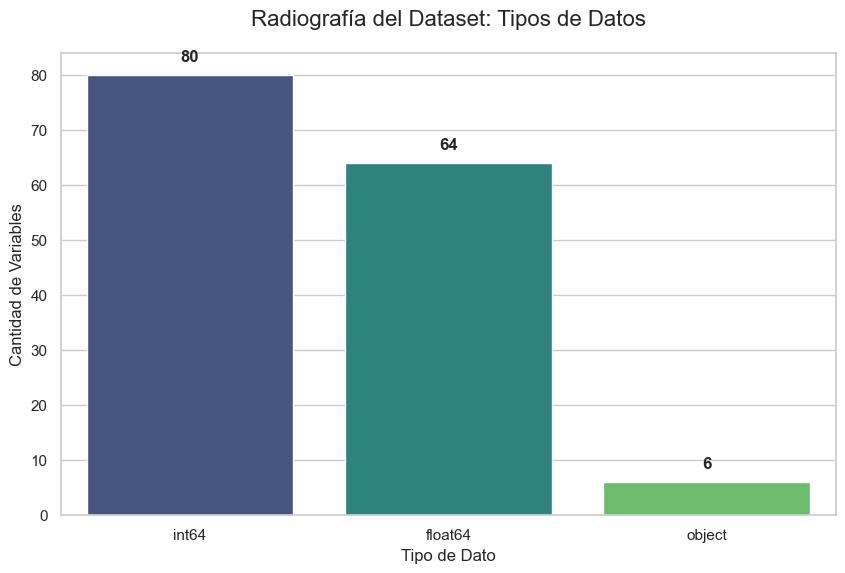

📊 Inventario Completo de Variables por Tipo:


,Tipo de Dato,Cantidad,Variables
0,int64,80,"rank, matches_played, starts, minutes_played, goals, assists, goals_assists, non_penalty_goals, pk_goals, pk_attempts, yellow_cards, red_cards, progressive_carries, progressive_passes, progressive_runs, shots_total, shots_on_target, free_kick_shots, passes_completed, passes_attempted, pass_total_distance, pass_progressive_distance, key_passes, passes_final_third, passes_penalty_area, crosses_penalty_area, passes_live, passes_dead, passes_through_balls, passes_switches, passes_crosses, passes_throw_ins, corner_kicks, corner_kicks_in, corner_kicks_out, corner_kicks_straight, offsides, blocks, sca, sca_pass_live, sca_pass_dead, sca_dribble, fouls_drawn, sca_defense, gca, tackles_total, tackles_won, tackles_def_3rd, tackles_mid_3rd, tackles_att_3rd, challenges_lost, blocks_passes, interceptions, tackles_interceptions, clearances, errors_leading_to_goal, touches, touches_def_pen_area, touches_att_pen_area, dribbles_completed, dribbles_tackled, carries, carries_penalty_area, miscontrols, dispossessed, passes_received, matches_completed, matches_subbed_in, unused_sub, on_goals_for, on_goals_against, plus_minus, second_yellow_card, fouls_committed, pk_won, pk_conceded, own_goals, ball_recoveries, aerials_won, team_order"
1,float64,64,"age, born, nineties, xg, npxg, xag, npxg_plus_xa, non_penalty_goals_assists, expected_goals_assists, shots_on_target_pct, shots_p90, shots_on_target_p90, goals_per_shot, goals_per_sot, avg_shot_distance, npxg_per_shot, goals_minus_xg, np_goals_minus_npxg, pass_completion_pct, xa, assists_minus_xa, sca_p90, gca_p90, challenge_tackles_pct, dribble_success_pct, dribbles_tackled_pct, minutes_per_match, minutes_pct, minutes_per_start, minutes_per_sub, points_per_match, plus_minus_p90, plus_minus_on_off, on_xg_for, on_xg_against, xg_plus_minus, xg_plus_minus_p90, aerials_won_pct, goals_against, goals_against_p90, shots_on_target_against, saves, save_pct, wins, draws, losses, clean_sheets, clean_sheet_pct, pk_allowed, pk_saved, pk_missed, psxg, psxg_per_sot, psxg_plus_minus, gk_passes_attempted_launch, gk_throws, launch_pct, avg_pass_length, gk_crosses_faced, crosses_stopped, crosses_stopped_pct, def_actions_outside_box, def_actions_outside_box_p90, avg_keeper_sweeper_dist"
2,object,6,"player_name, nation, main_position_group, squad, league_id, record_type"



ℹ️ Información General del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 150 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    player_name                  3006 non-null   object 
 1    nation                       3006 non-null   object 
 2    main_position_group          3006 non-null   object 
 3    squad                        3006 non-null   object 
 4    league_id                    3006 non-null   object 
 5    age                          3006 non-null   float64
 6    record_type                  3006 non-null   object 
 7    rank                         3006 non-null   int64  
 8    born                         3006 non-null   float64
 9    matches_played               3006 non-null   int64  
 10   starts                       3006 non-null   int64  
 11   minutes_played               3006 non-null   int64  
 12   nineties             

In [ ]:
# Análisis estructural de la base
# 1. Verificación de Dimensiones
print(f"📐 Dimensiones del Dataset: {df.shape[0]} filas x {df.shape[1]} columnas \n")

#==========================================================================================================

# 2. Preparación datos para el gráfico de tipos de variables

# 2.1. Obtención de los tipos de datos
dtype_counts = df.dtypes.value_counts()

# 2.2. Configuración Visual
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# 2.3. Gráfico de Barras
barplot = sns.barplot(x=dtype_counts.index.astype(str), y=dtype_counts.values, palette='viridis')

# 2.4. Títulos y Etiquetas
plt.title('Radiografía del Dataset: Tipos de Datos', fontsize=16, pad=20)
plt.xlabel('Tipo de Dato', fontsize=12)
plt.ylabel('Cantidad de Variables', fontsize=12)

# 2.5. Añadir etiquetas de valor sobre las barras
for i, v in enumerate(dtype_counts.values):
    barplot.text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.show()

#==========================================================================================================

# 3. Tabla completa de tipo de datos

# 3.1 Agrupación columnas por tipo de dato
dtype_summary = df.columns.to_series().groupby(df.dtypes).apply(list).reset_index()
dtype_summary.columns = ['Tipo de Dato', 'Lista de Variables']

# 3.2 Añadir conteo
dtype_summary['Cantidad'] = dtype_summary['Lista de Variables'].apply(len)

# 3.3 Formatear la lista completa (Sin truncar)

# Se unió toda la lista en un solo string separado por comas
dtype_summary['Variables'] = dtype_summary['Lista de Variables'].apply(lambda x: ', '.join(x))

# 3.4 Configuración para ver TODO el texto
pd.set_option('display.max_colwidth', None)

# 3.5 Mostrar tabla
print("📊 Inventario Completo de Variables por Tipo:")
display(dtype_summary[['Tipo de Dato', 'Cantidad', 'Variables']])


#==========================================================================================================

# 4. Información Técnica Completa (Memoria, Nulos, Dtypes)
print("\nℹ️ Información General del DataFrame:")
df.info(verbose=True, show_counts=True)

In [ ]:
# ==============================================================================
# ERRORES PROVENIENTES DEL ETL
# ==============================================================================
"""
    
print("\n" + "="*50)
print("1. VISIÓN GENERAL (HEALTH CHECK)")
print("="*50)

# A. Integridad de la Base (Nulos)
#    Aquí se crea específicamente un df que proporcione los valores nulos y otros tipos de datos más

def elite_audit(df):

    # Genera un reporte de salud básico del dataframe.
    
    # 1. Tipos de datos
    audit = pd.DataFrame(df.dtypes, columns=['Dtype'])
    
    # 2. Conteo de nulos y porcentaje
    audit['Nulos'] = df.isnull().sum()
    audit['% Nulos'] = (df.isnull().sum() / len(df)) * 100
    
    # 3. Valores únicos (Cardinalidad)
    audit['Unicos'] = df.nunique()
    
    # 4. Memoria (opcional, bueno para Big Data)
    audit['Memoria_KB'] = df.memory_usage(deep=True) // 1024
    
    
    return audit.sort_values(by='% Nulos', ascending=False)

# Ejecución de la auditoría

reporte = elite_audit(df)
display(reporte)

"""




1. VISIÓN GENERAL (HEALTH CHECK)


,Dtype,Nulos,% Nulos,Unicos,Memoria_KB
minutes_per_sub,float64,152,5.056554,62,23
aerials_won_pct,float64,152,5.056554,472,23
minutes_pct,float64,152,5.056554,874,23
minutes_per_start,float64,152,5.056554,52,23
save_pct,float64,152,5.056554,122,23
pass_completion_pct,float64,152,5.056554,416,23
dribbles_tackled_pct,float64,152,5.056554,350,23
shots_on_target_pct,float64,152,5.056554,278,23
dribble_success_pct,float64,152,5.056554,343,23
clean_sheet_pct,float64,152,5.056554,88,23


In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""
#====================================================================================

#   nulos_float = reporte[(reporte['% Nulos'] > 0) & (reporte['Dtype'] == 'float64')]
#   nulos_float



In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""
#====================================================================================

# Quiero ver ahora si es que los valores nulos de las columnas que presentan valores NaN en columnas float, se concentran en algún "squad" específico, por ejemplo "COMBINADAS"

#   nulos_float_squads = df[df[nulos_float.index].isnull().any(axis=1)]['squad'].value_counts()
#   display(nulos_float_squads)

#   print('Las variables que quedaron con valores NaN son porcentajes "_pct", ' \
#   'o bien otras variables que no serían correcto sumarlas en las COMBINADAS. ' \
#   '\nSe tratará en la featuring engeneering esto. ')

# Ejemplo para ver que en las 

#   df[df[nulos_float.index].isnull().any(axis=1)].head(10)

In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""

#====================================================================================

"""reporte_age_nulos = reporte.loc[reporte.index == 'age']
   display(reporte_age_nulos)

# Obtención del nombre de los jugadores que no tienen edad, año de nacimiento ni nacion registrada en el dataframe original df.

   jugadores_sin_datos = df[df['age'].isnull()][['player_name', 'age','born','nation']]
   display(jugadores_sin_datos)

# Como ya se corrigió el problema en el ETL entonces el problema fue solucionado

   if jugadores_sin_datos.shape[0]:
       print(f"Se encontraron {len(jugadores_sin_datos)} jugadores sin datos:")
       for g in jugadores_sin_datos:
           print("  -", ", ".join(g))
   else:
       print("No se encontraron jugadores sin datos de 'age', 'born' o 'nation'." \
       "\nTrabajo Completado!") """


In [ ]:
"""Esta parte fue para realizar el análisis de los datos faltantes que se encontraron
y se solucionaron reacomodando el archivo 00_etl. 

Cómo ya no ofrece nada se optó por dejarlo oculto al código."""

# Busca columnas que tienen exactamente los mismos valores (incluyendo NaN en mismas posiciones)
#   columnas_duplicadas = []
#   _checked = set()
#   cols = df.columns.tolist()

""" for i, c in enumerate(cols):
    if c in _checked:
        continue
    grupo = [c]
    for c2 in cols[i+1:]:
        # Series.equals considera NaN en mismas posiciones como iguales
        if df[c].equals(df[c2]):
            grupo.append(c2)
            _checked.add(c2)
    if len(grupo) > 1:
        columnas_duplicadas.append(grupo)

# Resultado legible
if columnas_duplicadas:
    print(f"Se encontraron {len(columnas_duplicadas)} grupos de columnas duplicadas (por contenido):")
    for g in columnas_duplicadas:
        print("  -", ", ".join(g))
else:
    print("No se encontraron columnas duplicadas por contenido." \
    "\nTrabajo completado!") """

📊 Generando Auditoría de Nulos en 3 partes para 150 variables...
Amarillo = nulo, Violeta = dato


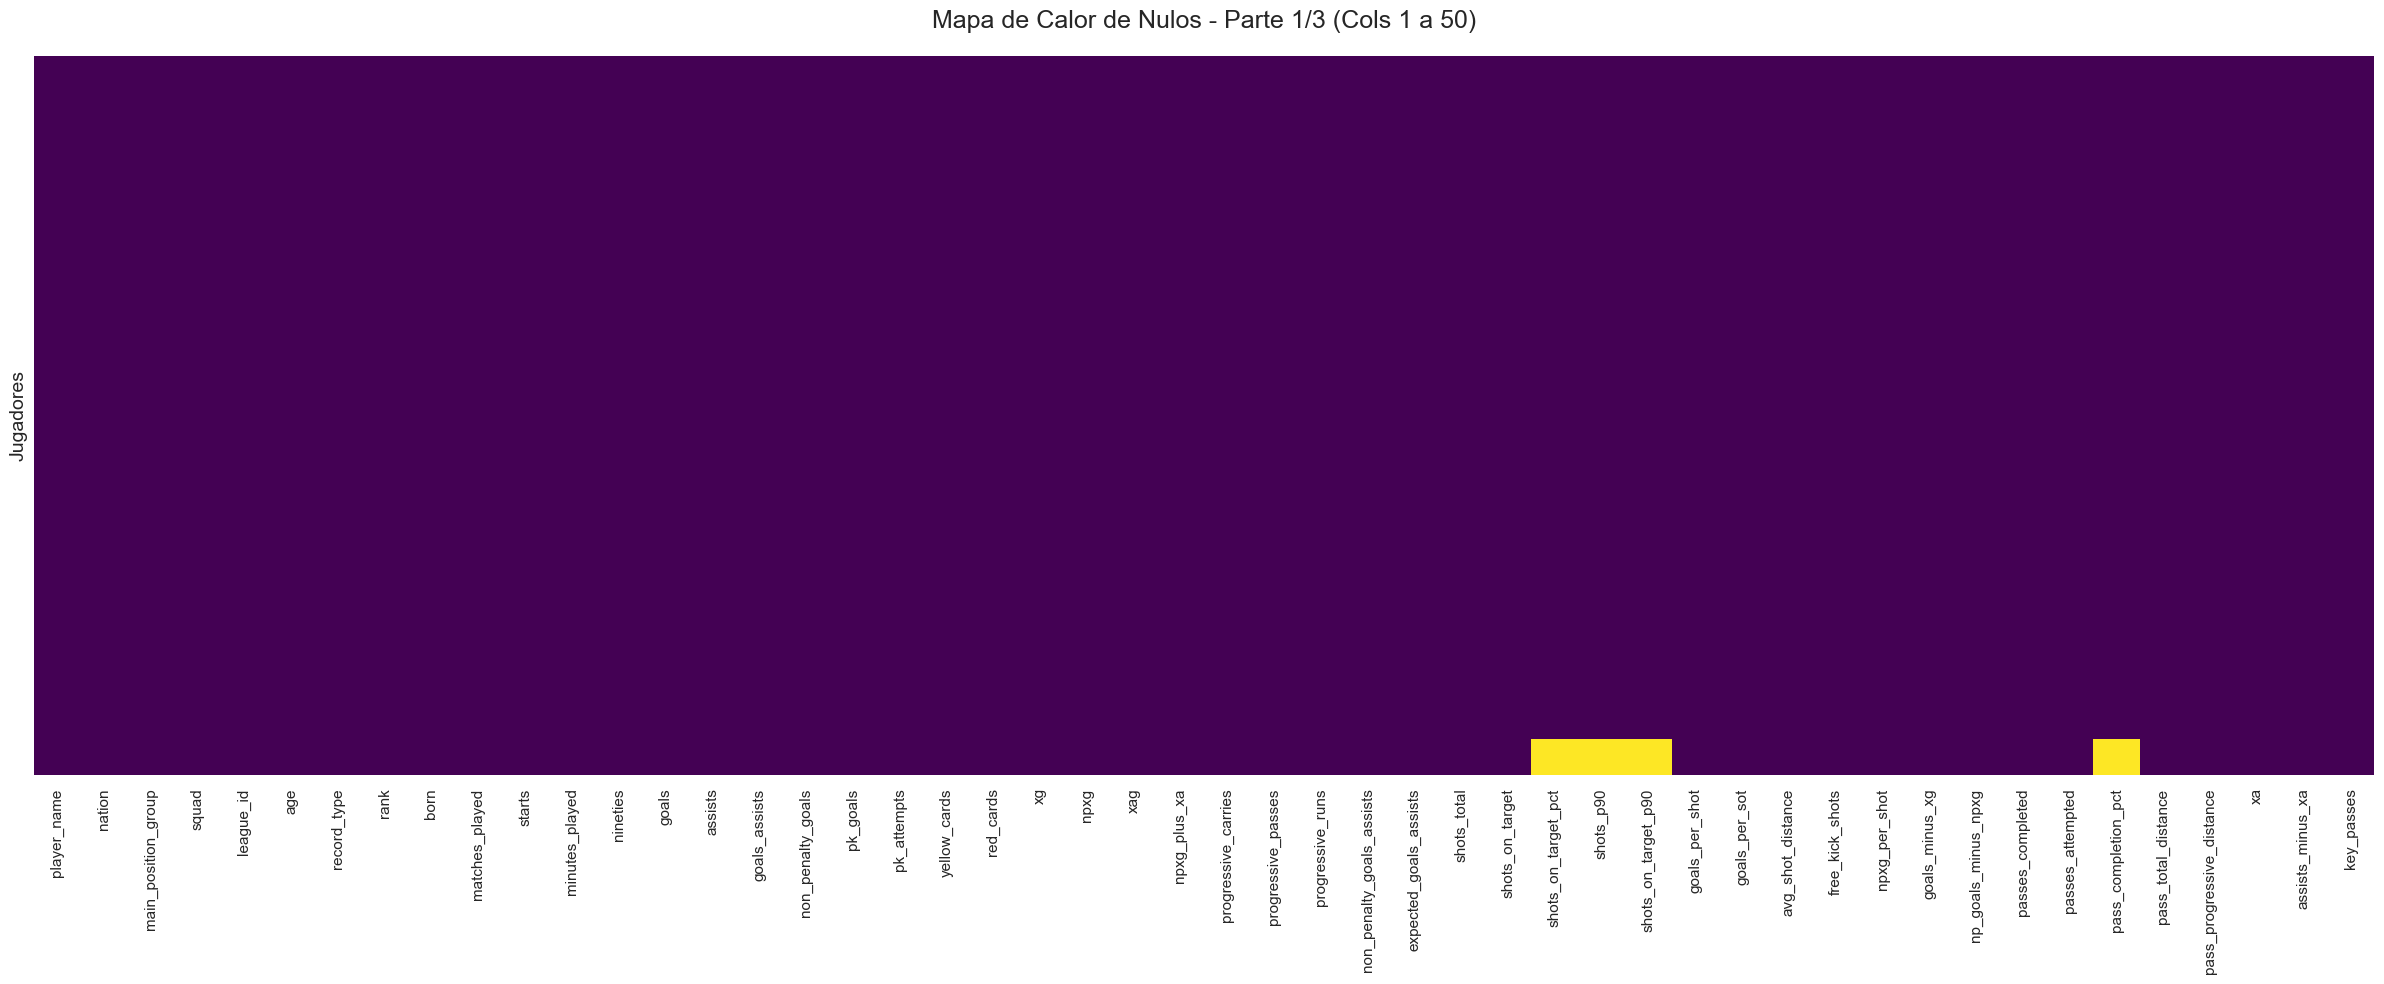

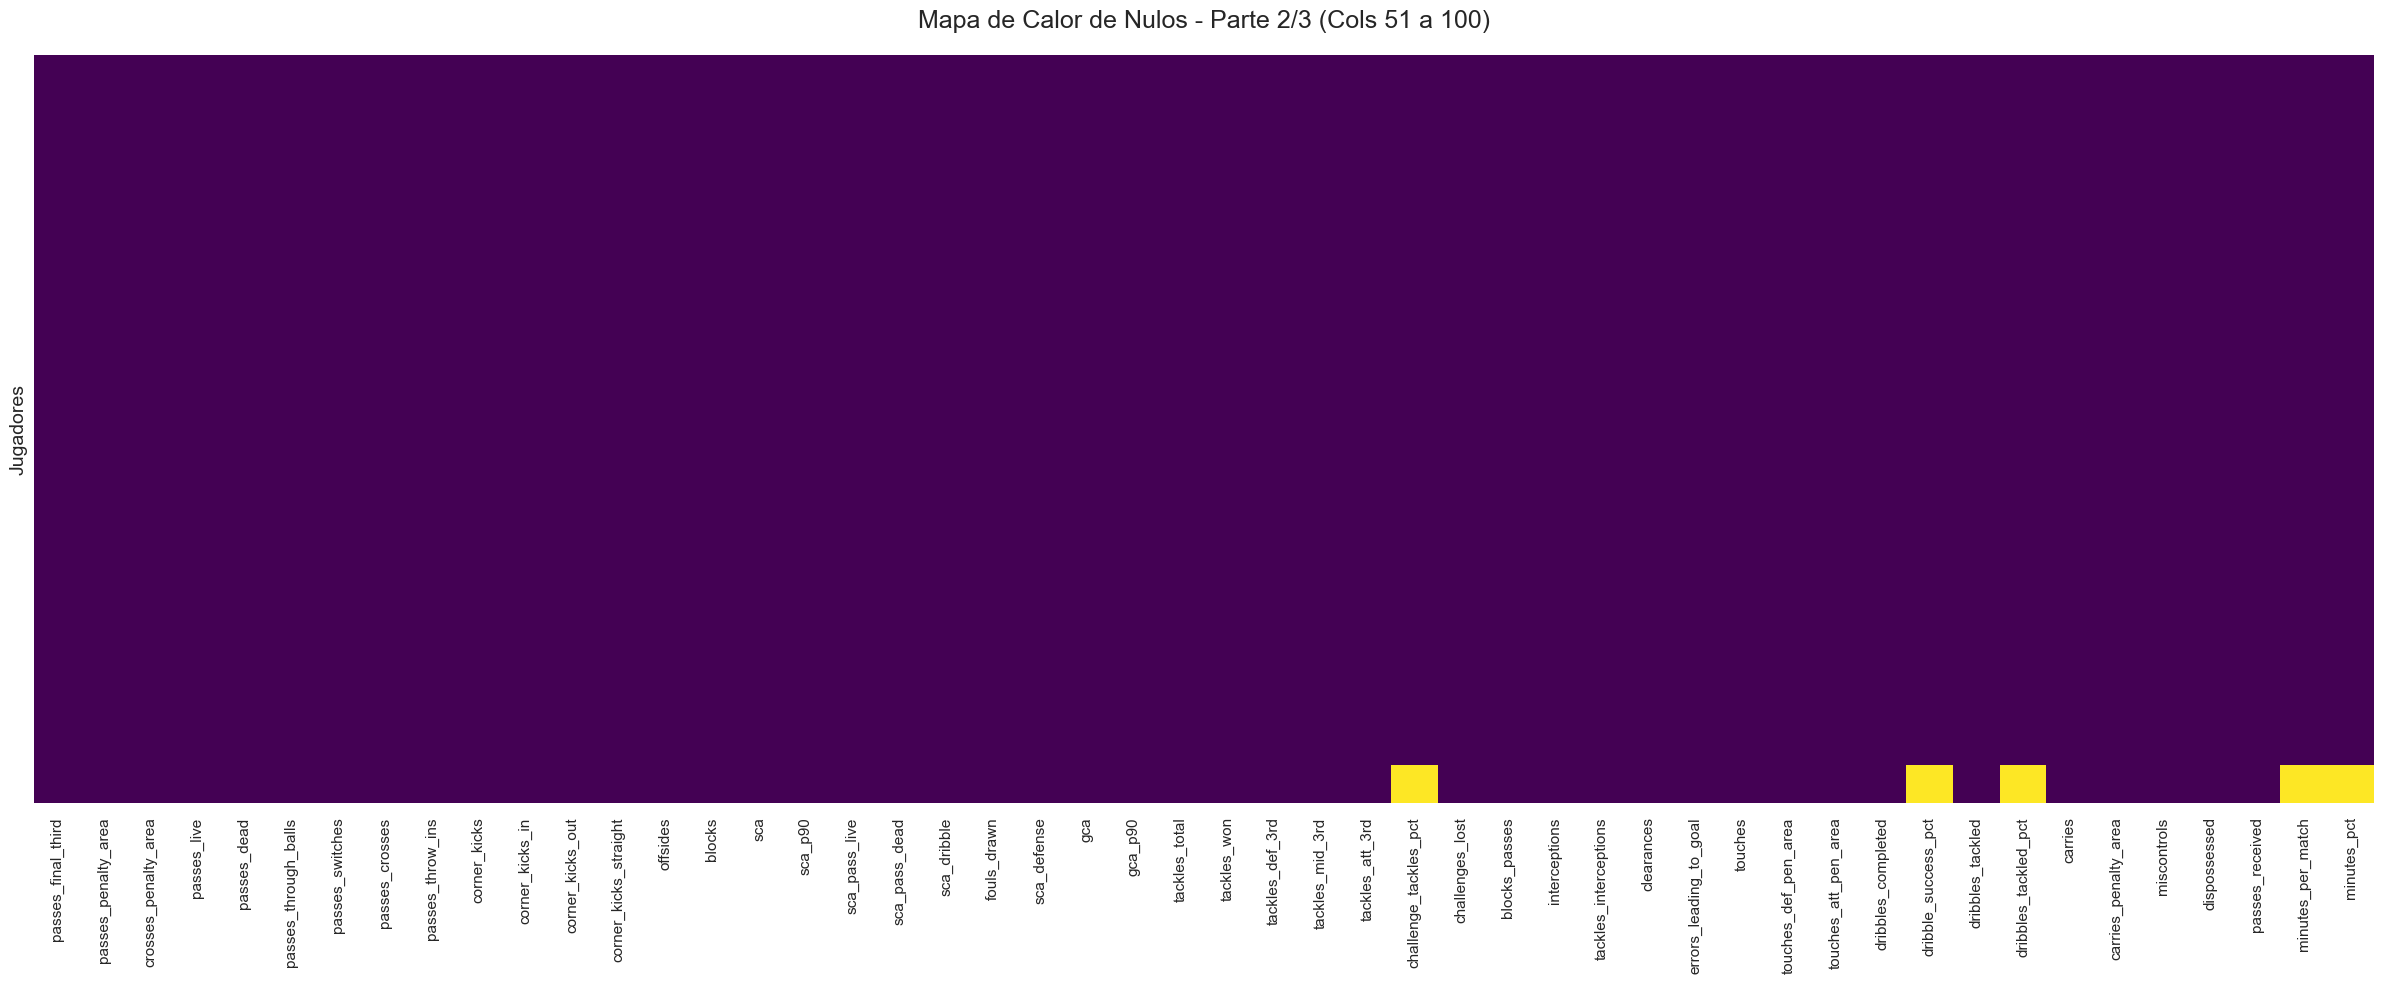

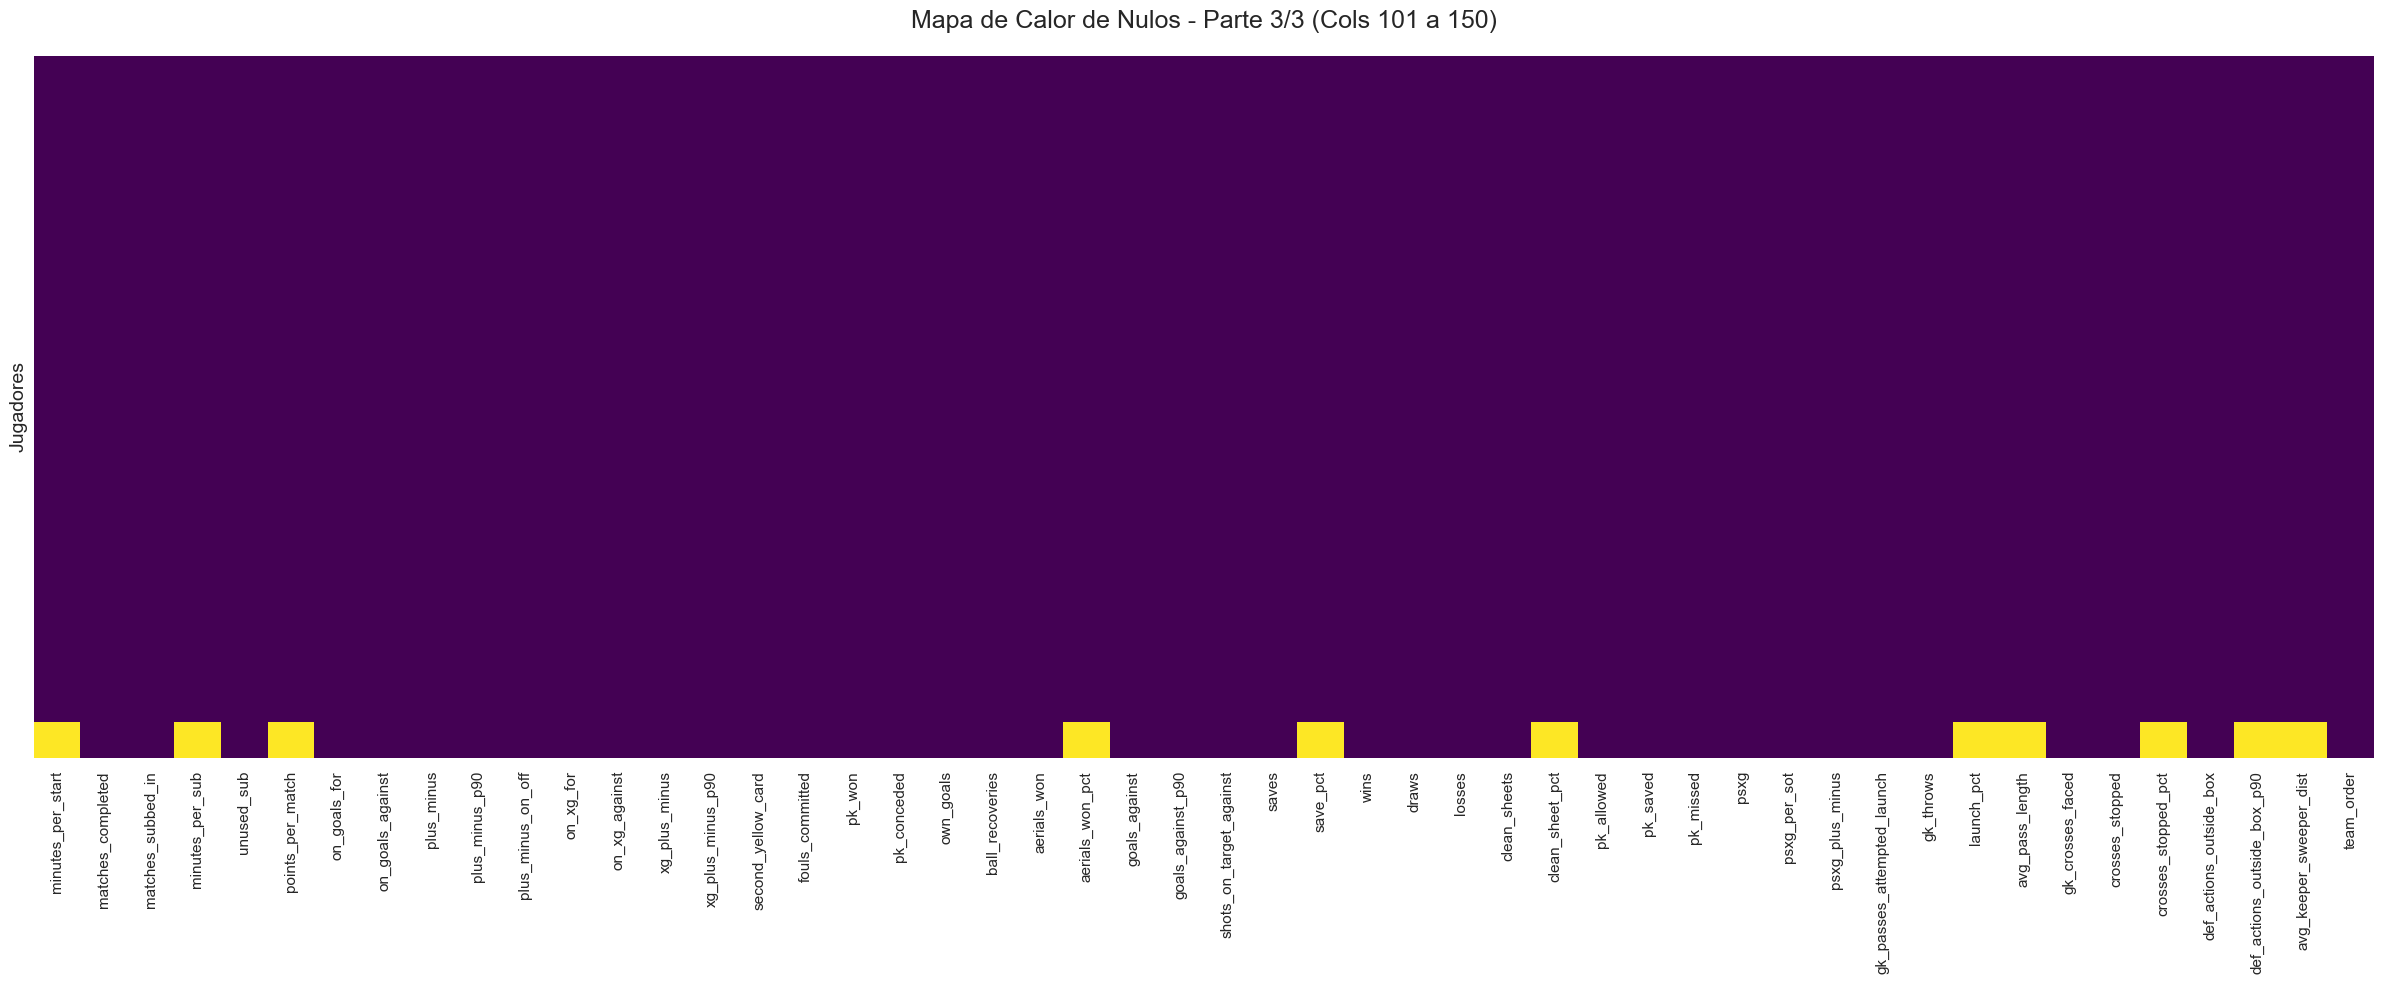

In [ ]:
# MAPAS DE CALOR DE NULOS

# 1. Configuración del gráfico

sns.set_theme(style="whitegrid")

# 2. Lógica de División (Chunking)
chunk_size = 50 # Cantidad de columnas por gráfico
total_cols = len(df.columns)
num_chunks = math.ceil(total_cols / chunk_size)

print(f"📊 Generando Auditoría de Nulos en {num_chunks} partes para {total_cols} variables...\nAmarillo = nulo, Violeta = dato")

# 3. Generación de Gráficos
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, total_cols)
    
    # Seleccionar subconjunto
    df_subset = df.iloc[:, start:end]
    
    # Crear Figura
    plt.figure(figsize=(24, 10)) # Ancho extra para leer los nombres
    
    # Mapa de Calor (Amarillo = Nulo, Violeta = Dato)
    sns.heatmap(df_subset.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    
    # Títulos y Etiquetas
    plt.title(f'Mapa de Calor de Nulos - Parte {i+1}/{num_chunks} (Cols {start+1} a {end})', fontsize=18, pad=20)
    plt.xticks(rotation=90, fontsize=11) # Rotar nombres para que se lean
    plt.ylabel('Jugadores', fontsize=14)
    
    plt.tight_layout()
    plt.show()

Filas COMBINED: 152
Filas SINGLE: 2854



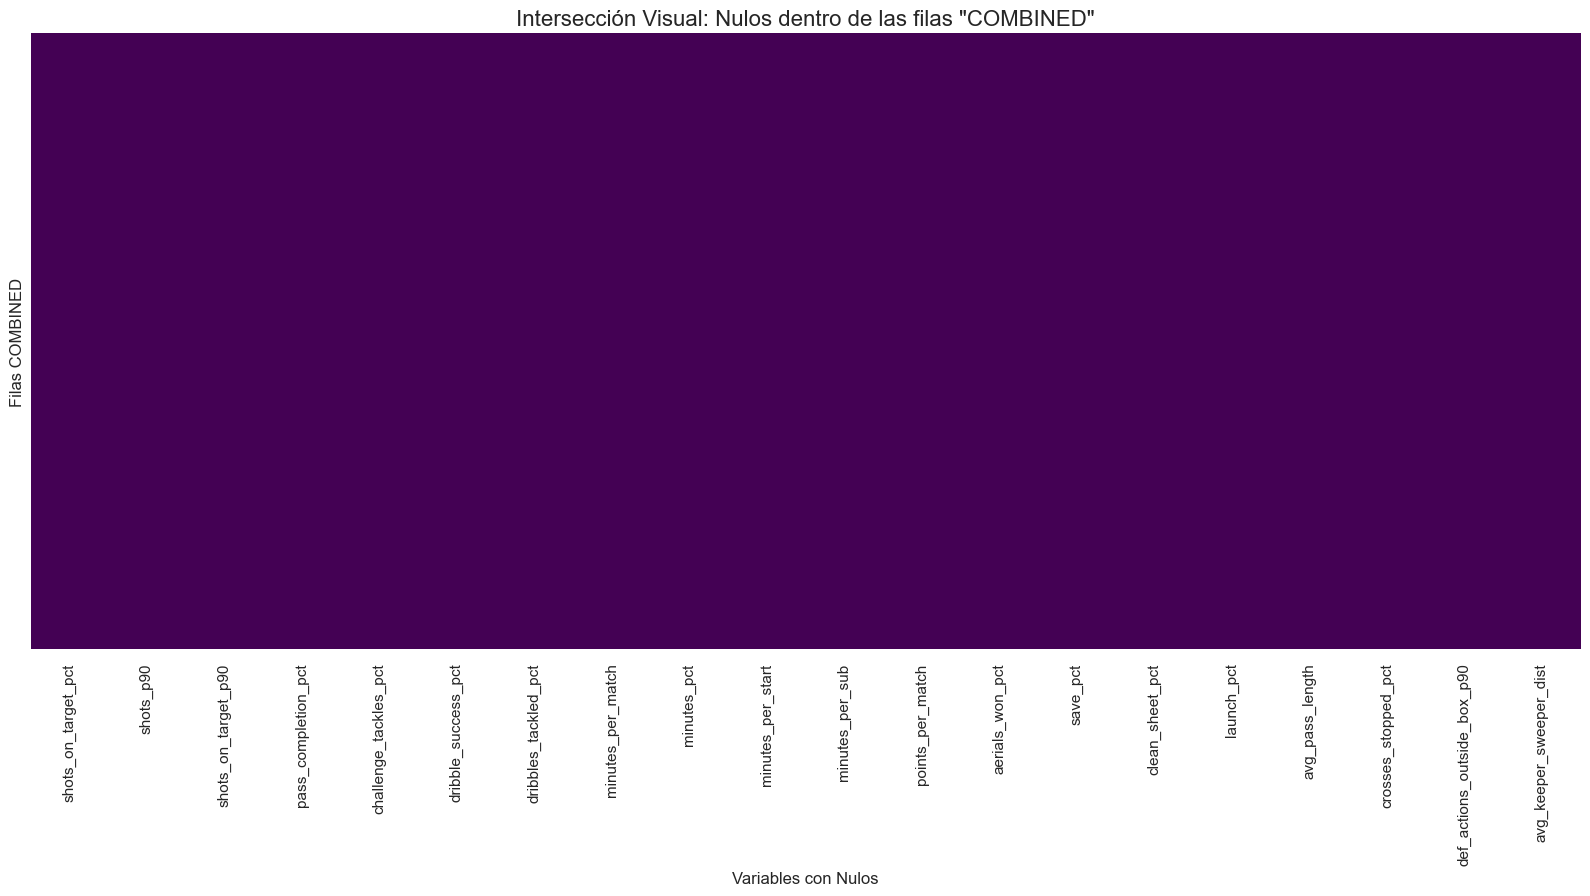



>>> EVIDENCIA DEL ETL (Variables anuladas intencionalmente en Totales) <<<
                             % Nulos en COMBINED  % Nulos en SINGLE
shots_on_target_pct                        100.0                0.0
crosses_stopped_pct                        100.0                0.0
avg_pass_length                            100.0                0.0
launch_pct                                 100.0                0.0
clean_sheet_pct                            100.0                0.0
save_pct                                   100.0                0.0
aerials_won_pct                            100.0                0.0
points_per_match                           100.0                0.0
minutes_per_sub                            100.0                0.0
minutes_per_start                          100.0                0.0
minutes_pct                                100.0                0.0
minutes_per_match                          100.0                0.0
dribbles_tackled_pct                   

In [ ]:
# Aquí se comprueba que los valores nulos se corresponden con los valores "COMBINED"

# 1. Separar el universo en dos: 'Combined' (Totales) vs 'Single' (Equipos individuales)
df_combined = df[df['squad'] == 'COMBINED']
df_single = df[df['squad'] != 'COMBINED']

print(f"Filas COMBINED: {len(df_combined)}")
print(f"Filas SINGLE: {len(df_single)}")
print('\n',"=" * 80)

# 2. Identificar columnas con Nulos
# Solo nos interesan las columnas que tienen algún dato faltante
cols_with_nulls = df.columns[df.isnull().any()].tolist()

if not cols_with_nulls:
    print("¡No hay nulos en el dataset!")
else:
    # --- VISUALIZACIÓN 1: MAPA DE CALOR SOLO DE 'COMBINED' ---
    plt.figure(figsize=(20, 8))
    # Filtramos el DF para ver solo filas COMBINED y solo columnas problemáticas
    sns.heatmap(df_combined[cols_with_nulls].isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Intersección Visual: Nulos dentro de las filas "COMBINED"', fontsize=16)
    plt.xlabel('Variables con Nulos')
    plt.ylabel('Filas COMBINED')
    plt.xticks(rotation=90)
    plt.show()

    # --- ANÁLISIS 2: COMPARATIVA NUMÉRICA (LA PRUEBA DE FUEGO) ---
    # Calculamos el % de nulos en cada grupo
    null_pct_combined = df_combined[cols_with_nulls].isnull().mean() * 100
    null_pct_single = df_single[cols_with_nulls].isnull().mean() * 100

    # Creamos un DataFrame para comparar
    comparison = pd.DataFrame({
        '% Nulos en COMBINED': null_pct_combined,
        '% Nulos en SINGLE': null_pct_single
    })
    
# 3. Filtramos para ver donde la diferencia es drástica (Hipótesis del ETL)

# Mostramos columnas donde Combined es 100% nulo pero Single tiene datos
print('\n',"=" * 80)
print("\n>>> EVIDENCIA DEL ETL (Variables anuladas intencionalmente en Totales) <<<")
pd.set_option('display.max_rows', None)
print(comparison[comparison['% Nulos en COMBINED'] > 90].sort_values('% Nulos en SINGLE'))

nulos = reporte[(reporte['% Nulos'] > 0)]

print('\n',"=" * 80)

print("\nEsta es la cantidad de columnas con valores nulos:", len(nulos))

In [ ]:
# Aquí se vió que era lo que contenía la columna 'unkdown_p90'. Su correción se aplicó al ETL.

#df_residual = df['unknown_p90']
#df_residual.unique()

"""
Al ver los valores (entre -2.72 y +1.17) y compararlos con las métricas de arqueros en FBref, 
esta columna es casi con seguridad PSxG+/- /90 (Post-Shot Expected Goals minus Goals Allowed per 90 minutes). 
Es decir, "cuántos goles extra salvó el arquero por partido.
Dado que ya tenemos la columna PSxG+/- (total), tener el "per 90" es redundante porque podemos calcularlo 
nosotros mismos (PSxG+/- dividido 90s). Por lo tanto, se eliminará esta columna. 
Para eliminarla se hará quitará la columna directamente en el ETL.
"""

KeyError: 'unknown_p90'

⚠️ Se encontraron 20 variables con datos faltantes.


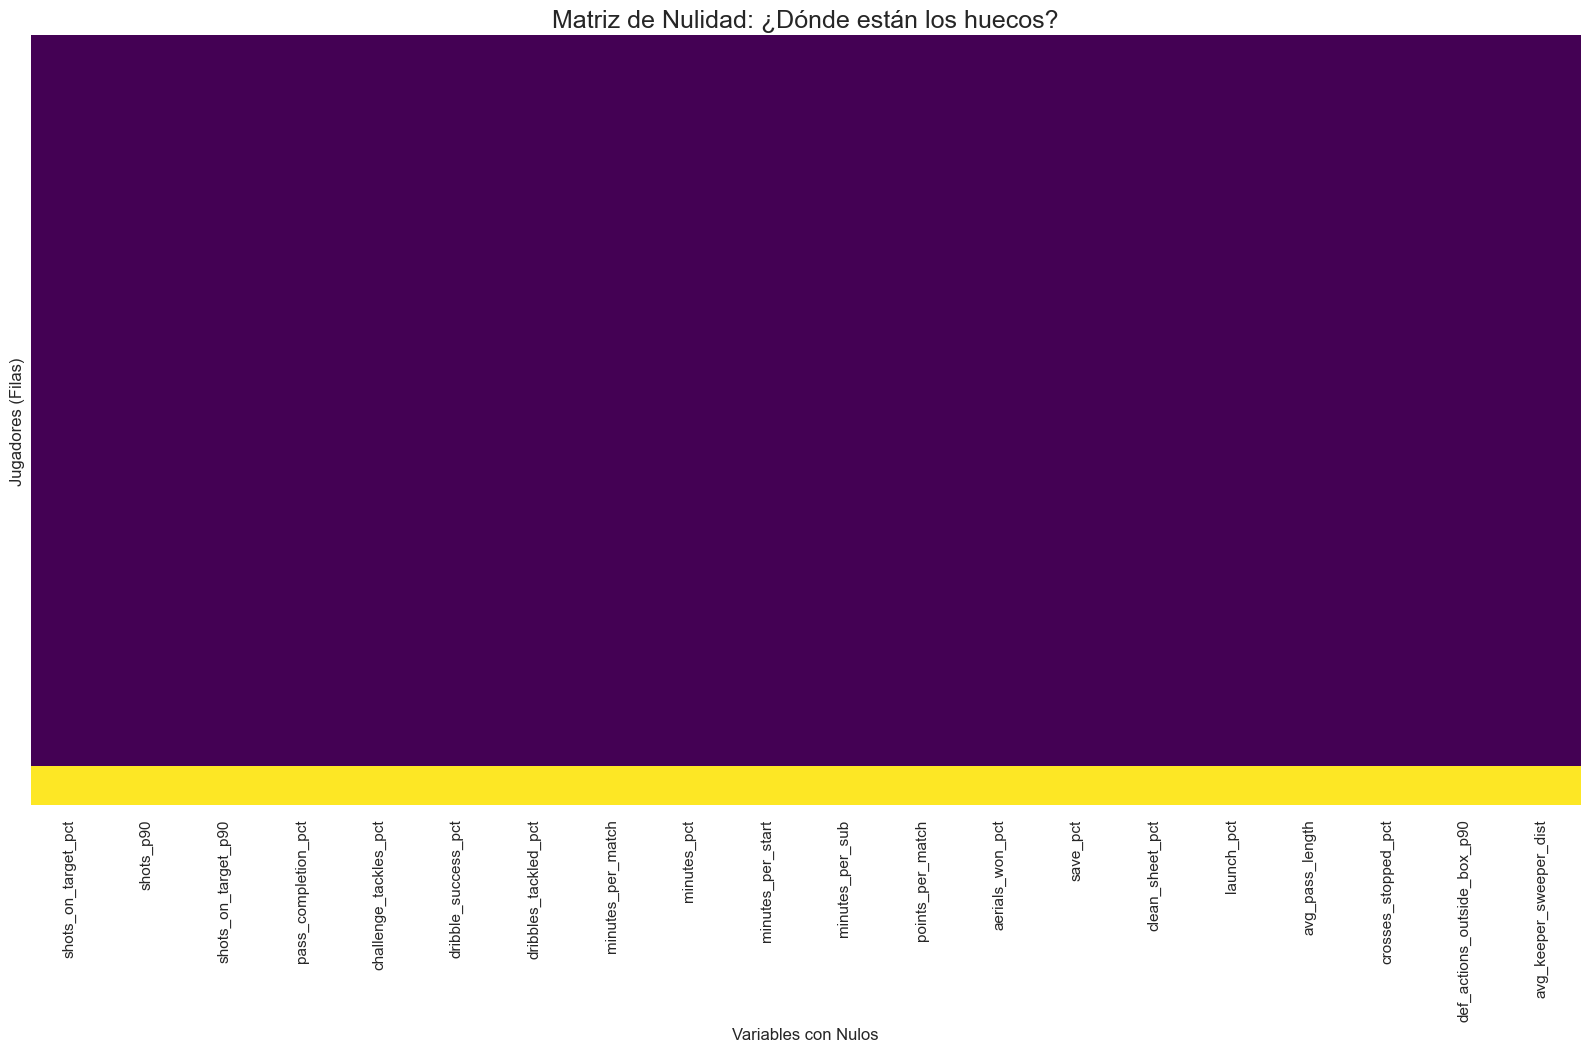

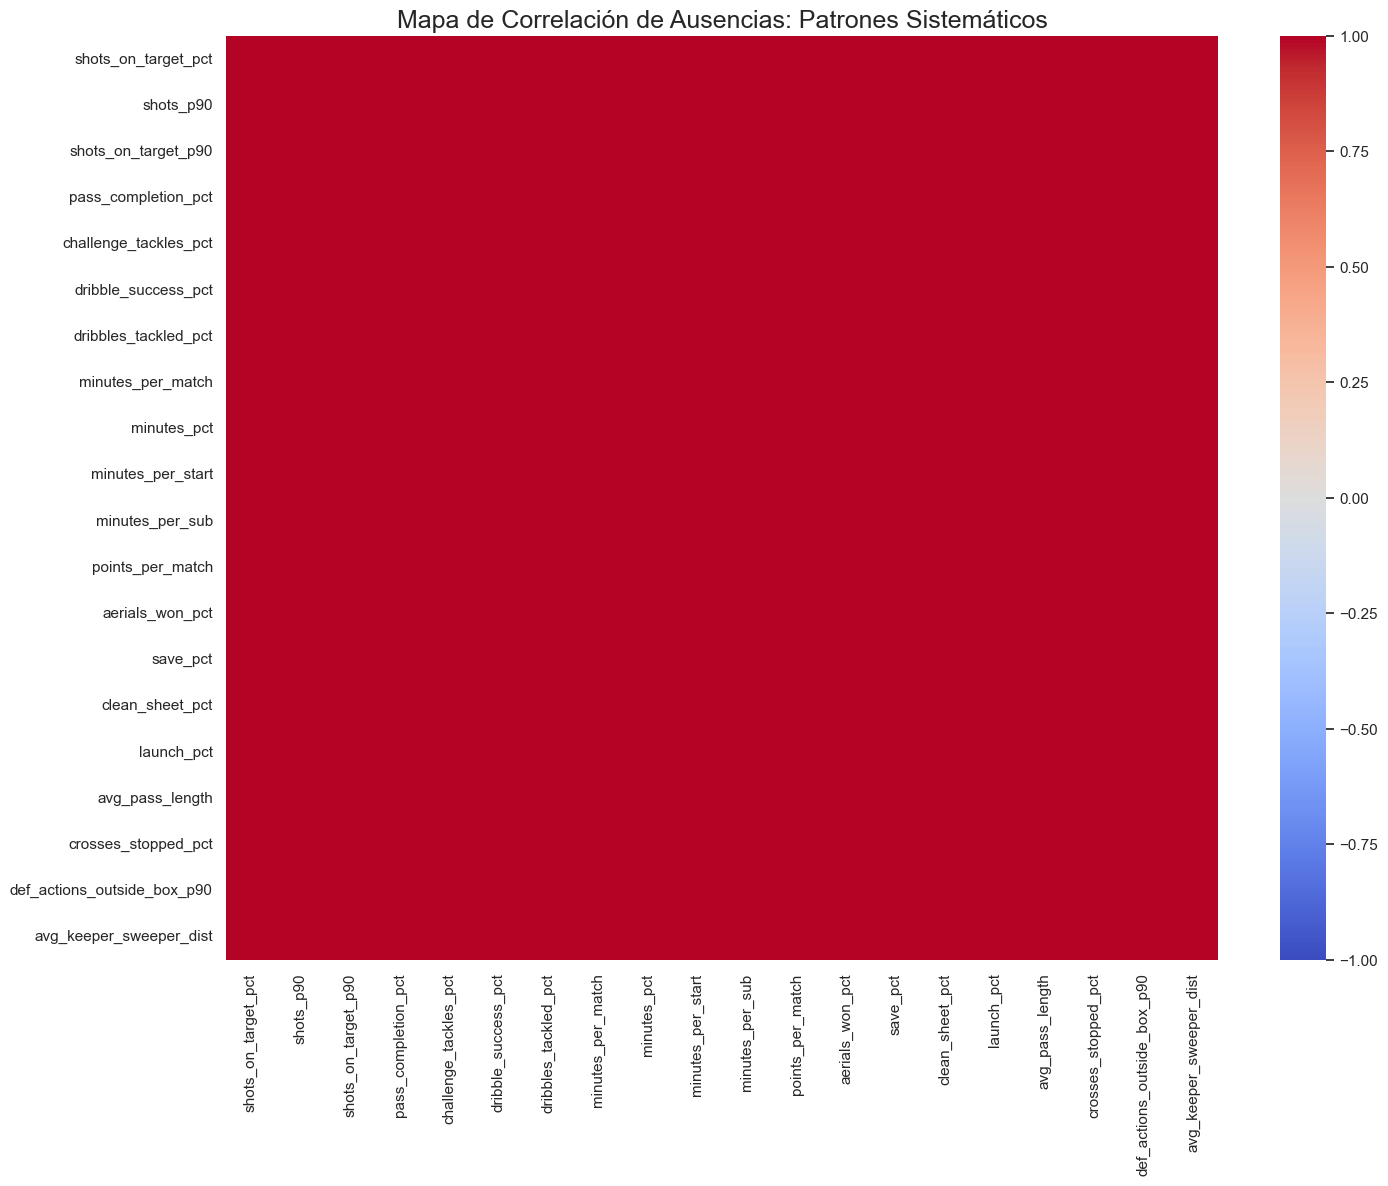

💡 INTERPRETACIÓN:
1. Si ves bloques verticales amarillos en la Matriz, son variables vacías para grupos específicos (ej. Arqueros).
2. Si ves cuadros rojos grandes en la Correlación, significa que esas variables faltan juntas (ej. Todos los porcentajes % en filas Total).


In [ ]:
# Matriz de Nulidad (Heatmap de ausencias)

# 1. Filtrar solo columnas que tienen algún nulo
# (Si graficamos las 150 columnas, no se verá nada. Nos enfocamos en el problema)
cols_with_nulls = df.columns[df.isnull().any()].tolist()

if len(cols_with_nulls) == 0:
    print("✅ ¡Increíble! No hay un solo valor nulo en todo el dataset.")
else:
    print(f"⚠️ Se encontraron {len(cols_with_nulls)} variables con datos faltantes.")
    
    # --- GRÁFICO A: MATRIZ DE NULIDAD (Missingness Matrix) ---
    # Esto nos muestra DÓNDE están los nulos.
    # Eje X: Variables. Eje Y: Jugadores. Color: Dato faltante.
    plt.figure(figsize=(20, 10))
    sns.heatmap(df[cols_with_nulls].isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Matriz de Nulidad: ¿Dónde están los huecos?', fontsize=18)
    plt.xlabel('Variables con Nulos')
    plt.ylabel('Jugadores (Filas)')
    plt.xticks(rotation=90)
    plt.show()

    # --- GRÁFICO B: CORRELACIÓN DE NULIDAD (Systematic Pattern) ---
    # Esto responde: "Si falta A, ¿también falta B?"
    # 1 = Correlación perfecta (si falta uno, falta el otro).
    plt.figure(figsize=(16, 12))
    nullity_corr = df[cols_with_nulls].isnull().corr()
    
    sns.heatmap(nullity_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Mapa de Correlación de Ausencias: Patrones Sistemáticos', fontsize=18)
    plt.show()

    # Insight Automático:
    print("💡 INTERPRETACIÓN:")
    print("1. Si ves bloques verticales amarillos en la Matriz, son variables vacías para grupos específicos (ej. Arqueros).")
    print("2. Si ves cuadros rojos grandes en la Correlación, significa que esas variables faltan juntas (ej. Todos los porcentajes % en filas Total).")

In [ ]:
# ANALISIS DE DUPLICADOS

print(f"📊 ANÁLISIS DE DUPLICADOS E INTEGRIDAD")
print("-" * 40)

# 1. Análisis de Duplicados Totales (Filas idénticas)
total_dups = df.duplicated().sum()
print(f"1. Filas Totalmente Duplicadas: {total_dups}")
if total_dups == 0:
    print("   ✅ APROBADO: No hay filas repetidas.")
else:
    print(f"   ❌ ALERTA: Se encontraron {total_dups} duplicados exactos.")

# 2. Análisis de Llave Primaria (Constraint Check)

# En este dataset, un jugador no puede aparecer dos veces en el mismo equipo
pk_cols = ['player_name', 'squad']
pk_dups = df.duplicated(subset=pk_cols).sum()

print(f"\n2. Duplicados de Llave Primaria {pk_cols}: {pk_dups}")
if pk_dups == 0:
    print("   ✅ APROBADO: La unicidad Jugador-Equipo es perfecta.")
else:
    print(f"   ❌ FALLO: Hay {pk_dups} violaciones de integridad referencial.")
    # Mostrar culpables
    print(df[df.duplicated(subset=pk_cols, keep=False)].sort_values('player_name'))

📊 ANÁLISIS DE DUPLICADOS E INTEGRIDAD
----------------------------------------
1. Filas Totalmente Duplicadas: 0
   ✅ APROBADO: No hay filas repetidas.

2. Duplicados de Llave Primaria ['player_name', 'squad']: 0
   ✅ APROBADO: La unicidad Jugador-Equipo es perfecta.


#### 2. Estadística Descriptiva de las Variables

C:\Users\Admin\AppData\Local\Temp\ipykernel_20288\4255694442.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='Tipo de Dato', y='Cantidad', palette=['#2ecc71', '#e74c3c'])


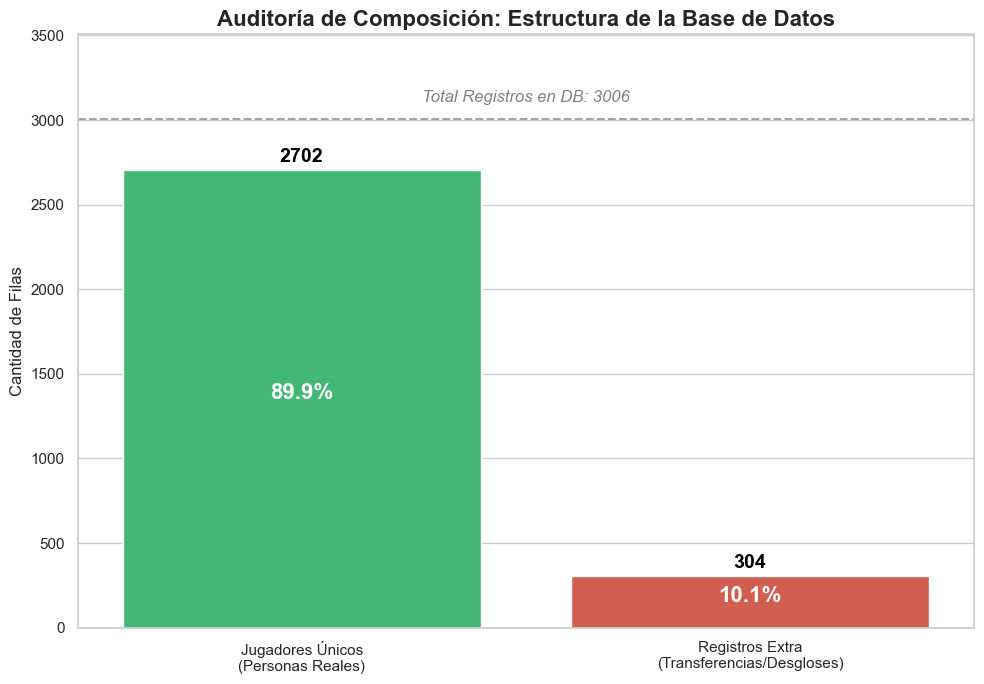

🔎 CONCLUSIÓN:
El dataset contiene 3006 filas.
Representan a 2702 atletas únicos.
Hay 304 filas adicionales que corresponden a desgloses por equipo de jugadores transferidos.
⚠️ RECORDATORIO: Para rankings de jugadores, usar siempre .drop_duplicates(subset='player_name') o filtrar 'record_type'.


In [ ]:
# COMPOSICIÓN DE LA BASE

# 1. Cálculos de Composición
total_filas = len(df)
jugadores_unicos = df['player_name'].nunique()
# Las filas "Extra" son la diferencia. Son las filas parciales de jugadores que se movieron.
filas_redundantes = total_filas - jugadores_unicos 

# 2. Crear un pequeño DataFrame para graficar
data_plot = pd.DataFrame({
    'Tipo de Dato': ['Jugadores Únicos\n(Personas Reales)', 'Registros Extra\n(Transferencias/Desgloses)'],
    'Cantidad': [jugadores_unicos, filas_redundantes]
})

# 3. Visualización
plt.figure(figsize=(10, 7))
sns.set_theme(style="whitegrid")

# Crear gráfico de barras
ax = sns.barplot(data=data_plot, x='Tipo de Dato', y='Cantidad', palette=['#2ecc71', '#e74c3c'])

# Títulos y Estilo
plt.title('Auditoría de Composición: Estructura de la Base de Datos', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad de Filas', fontsize=12)
plt.xlabel('')
plt.ylim(0, total_filas + 500) # Dar espacio arriba

# --- ETIQUETADO INTELIGENTE ---
for i, v in enumerate(data_plot['Cantidad']):
    # Poner el número total arriba de la barra
    ax.text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=14, color='black')
    
    # Poner el porcentaje dentro de la barra
    pct = (v / total_filas) * 100
    ax.text(i, v / 2, f"{pct:.1f}%", ha='center', fontweight='bold', fontsize=16, color='white')

# Línea de referencia del Total
plt.axhline(y=total_filas, color='gray', linestyle='--', alpha=0.7)
plt.text(0.5, total_filas + 100, f'Total Registros en DB: {total_filas}', 
         ha='center', color='gray', fontsize=12, style='italic')

plt.tight_layout()
plt.show()

# 4. Conclusión Texto
print(f"🔎 CONCLUSIÓN:")
print(f"El dataset contiene {total_filas} filas.")
print(f"Representan a {jugadores_unicos} atletas únicos.")
print(f"Hay {filas_redundantes} filas adicionales que corresponden a desgloses por equipo de jugadores transferidos.")
print(f"⚠️ RECORDATORIO: Para rankings de jugadores, usar siempre .drop_duplicates(subset='player_name') o filtrar 'record_type'.")

In [ ]:
# ESTADÍSTICA DESCRIPTIVA


# Se debe contar a cada persona UNA sola vez con sus números totales, ya que las estadísticas son del jugador en toda la temporada.
# 1. Lógica: Ordenar para que la fila 'Total' (team_order=0) quede primera, y borrar el resto.
df_sorted = df.sort_values(by=['player_name', 'team_order'], ascending=[True, True])
df_unique_global = df_sorted.drop_duplicates(subset='player_name', keep='first')

# 2. Configuración de Visualización
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # 2 decimales para limpieza

print(f"📊 ANÁLISIS DESCRIPTIVO GENERAL (Población Única Real: {len(df_unique_global)} Jugadores)")
print("="*80)

# -----------------------------------------------------------
# 2.1 VARIABLES NUMÉRICAS (Métricas de Juego)
# -----------------------------------------------------------
print("\n>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego por Jugador) <<<")
# describe() calcula count, mean, std, min, 25%, 50%, 75%, max
# Usamos el DF filtrado
numeric_stats = df_unique_global.describe().T

# Añadimos la Mediana explícitamente (es vital para ver sesgos)
numeric_stats['median'] = df_unique_global.median(numeric_only=True)

# Reordenamos para lectura analítica
cols_order = ['count', 'mean', 'median', 'std', 'min', 'max', '25%', '75%']
display(numeric_stats[cols_order])

# -----------------------------------------------------------
# 2.2. VARIABLES CATEGÓRICAS (Identificadores)
# -----------------------------------------------------------
print("\n>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<")
# include='object' analiza solo las columnas de texto
categorical_stats = df_unique_global.describe(include='object').T
display(categorical_stats)

📊 ANÁLISIS DESCRIPTIVO GENERAL (Población Única Real: 2702 Jugadores)

>>> RADIOGRAFÍA NUMÉRICA (Estadísticas de Juego por Jugador) <<<


,count,mean,median,std,min,max,25%,75%
age,2702.00,25.03,25.00,4.56,15.00,41.00,22.00,28.00
rank,2702.00,1432.28,1437.50,819.56,1.00,2853.00,727.25,2139.75
born,2702.00,1998.64,1999.00,4.56,1982.00,2009.00,1995.00,2002.00
matches_played,2702.00,20.08,22.00,11.39,1.00,54.00,10.00,30.00
starts,2702.00,14.26,12.50,11.37,0.00,38.00,3.00,24.00
minutes_played,2702.00,1279.68,1153.00,966.95,1.00,3420.00,373.00,2083.75
nineties,2702.00,14.22,12.80,10.74,0.00,38.00,4.10,23.10
goals,2702.00,1.78,0.00,3.25,0.00,31.00,0.00,2.00
assists,2702.00,1.27,0.00,1.99,0.00,18.00,0.00,2.00
goals_assists,2702.00,3.05,1.00,4.65,0.00,47.00,0.00,4.00



>>> RADIOGRAFÍA CATEGÓRICA (Texto y Etiquetas) <<<


,count,unique,top,freq
player_name,2702,2702,Aaron Ciammaglichella,1
nation,2702,113,ESP,402
main_position_group,2702,4,DF,969
squad,2702,97,COMBINED,152
league_id,2702,6,La Liga,553
record_type,2702,2,Parcial,2550


📊 Generando Mosaico para Población Única: 2702 jugadores
   - Variables a graficar: 144


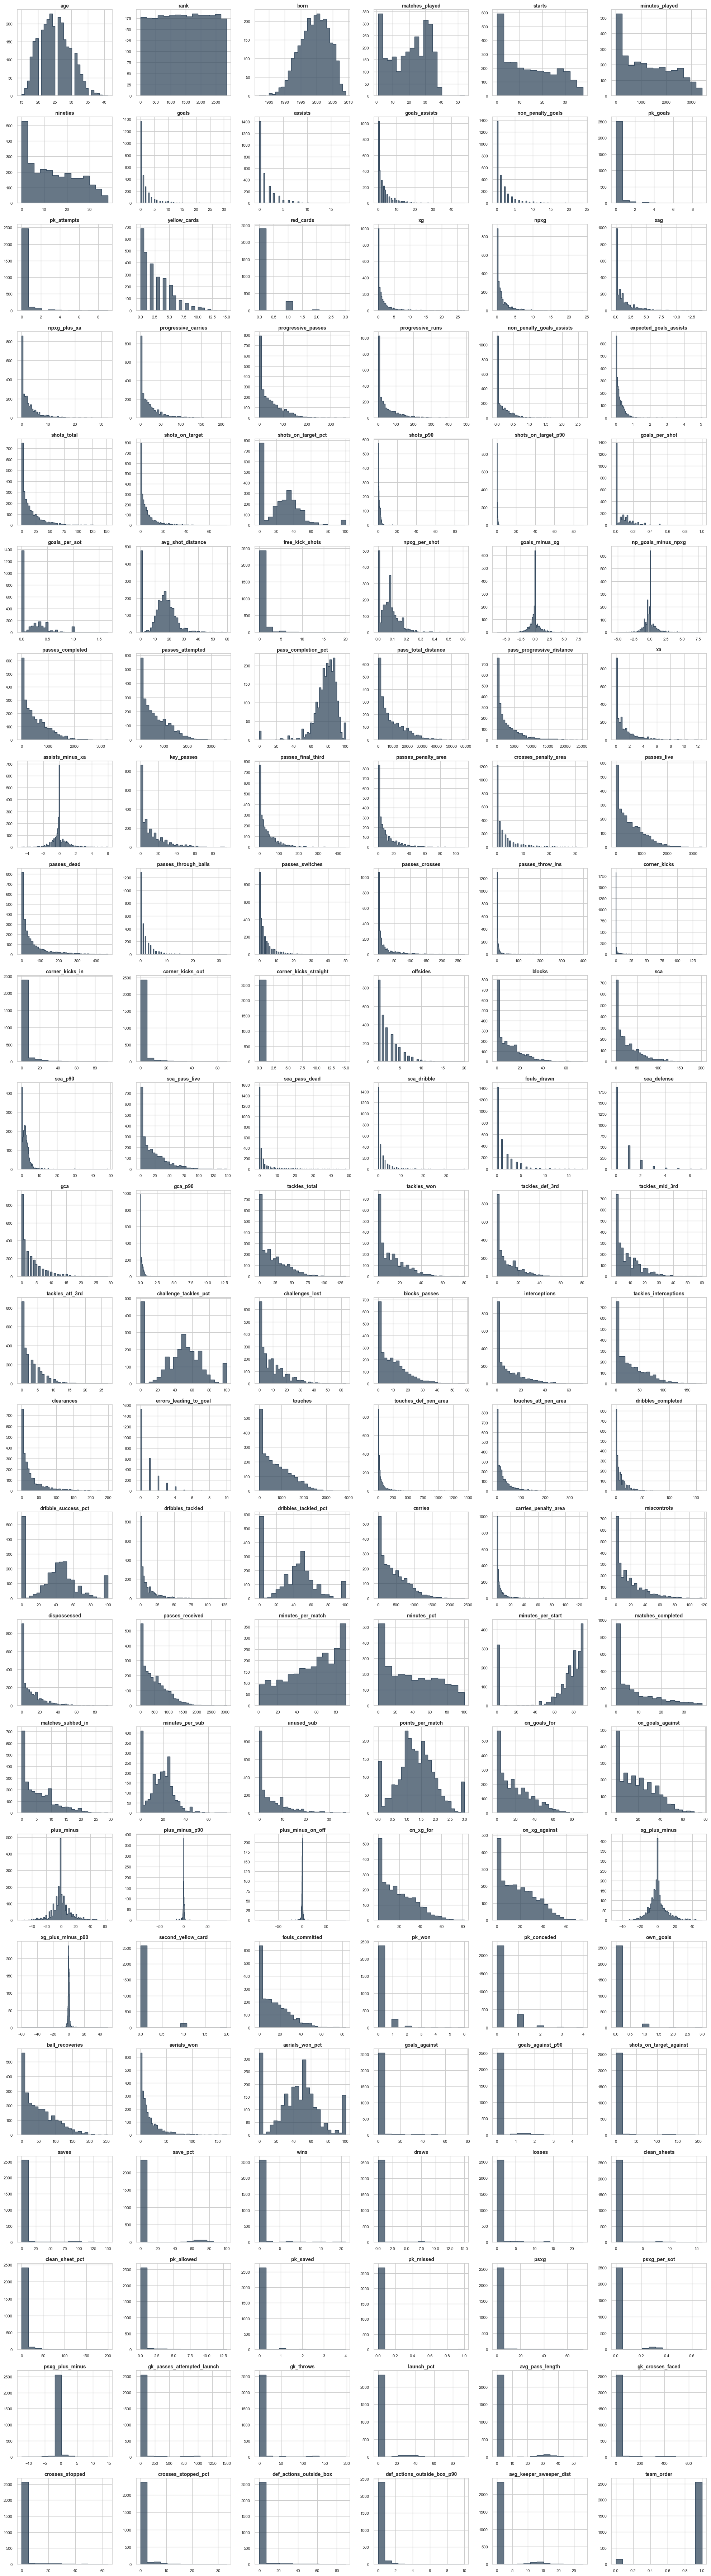

In [ ]:
# GRÁFICO DE DISTRIBUCIÓN DE TODAS LAS VARIABLES

# 1. Ordenamos para que 'Total' (team_order=0) quede arriba

df_sorted = df.sort_values(by=['player_name', 'team_order'], ascending=[True, True])
# Nos quedamos con un solo registro por jugador (el Total si existe)
df_unique = df_sorted.drop_duplicates(subset='player_name', keep='first')

print(f"📊 Generando Mosaico para Población Única: {len(df_unique)} jugadores")

# 2. Selección Inteligente de Variables
# 2.1. Solo Numéricas
numeric_cols = df_unique.select_dtypes(include=['float64', 'int64']).columns

# 2.2. Filtro de "Sombra de Datos" (Eliminar las muy vacías >50% nulos)
# Esto es vital para que el gráfico no se llene de cuadros vacíos
threshold = 0.5
null_pct = df_unique[numeric_cols].isnull().mean()
valid_cols = null_pct[null_pct < threshold].index.tolist()

total_cols = len(valid_cols)
cols_per_row = 6
rows = math.ceil(total_cols / cols_per_row)

print(f"   - Variables a graficar: {total_cols}")

# 3. Crear la Figura Gigante
plt.figure(figsize=(20, 3 * rows))
sns.set_theme(style="whitegrid")

for i, col in enumerate(valid_cols):
    ax = plt.subplot(rows, cols_per_row, i + 1)
    
    # --- LA CLAVE: Usamos df_unique en lugar de df ---
    sns.histplot(df_unique[col], kde=False, element="step", color="#34495e", ax=ax)
    
    # Estética limpia
    ax.set_title(col, fontsize=10, fontweight='bold', pad=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

👥 Población Total Única: 2702 jugadores
👥 Población para Análisis de Ligas: 2550 jugadores


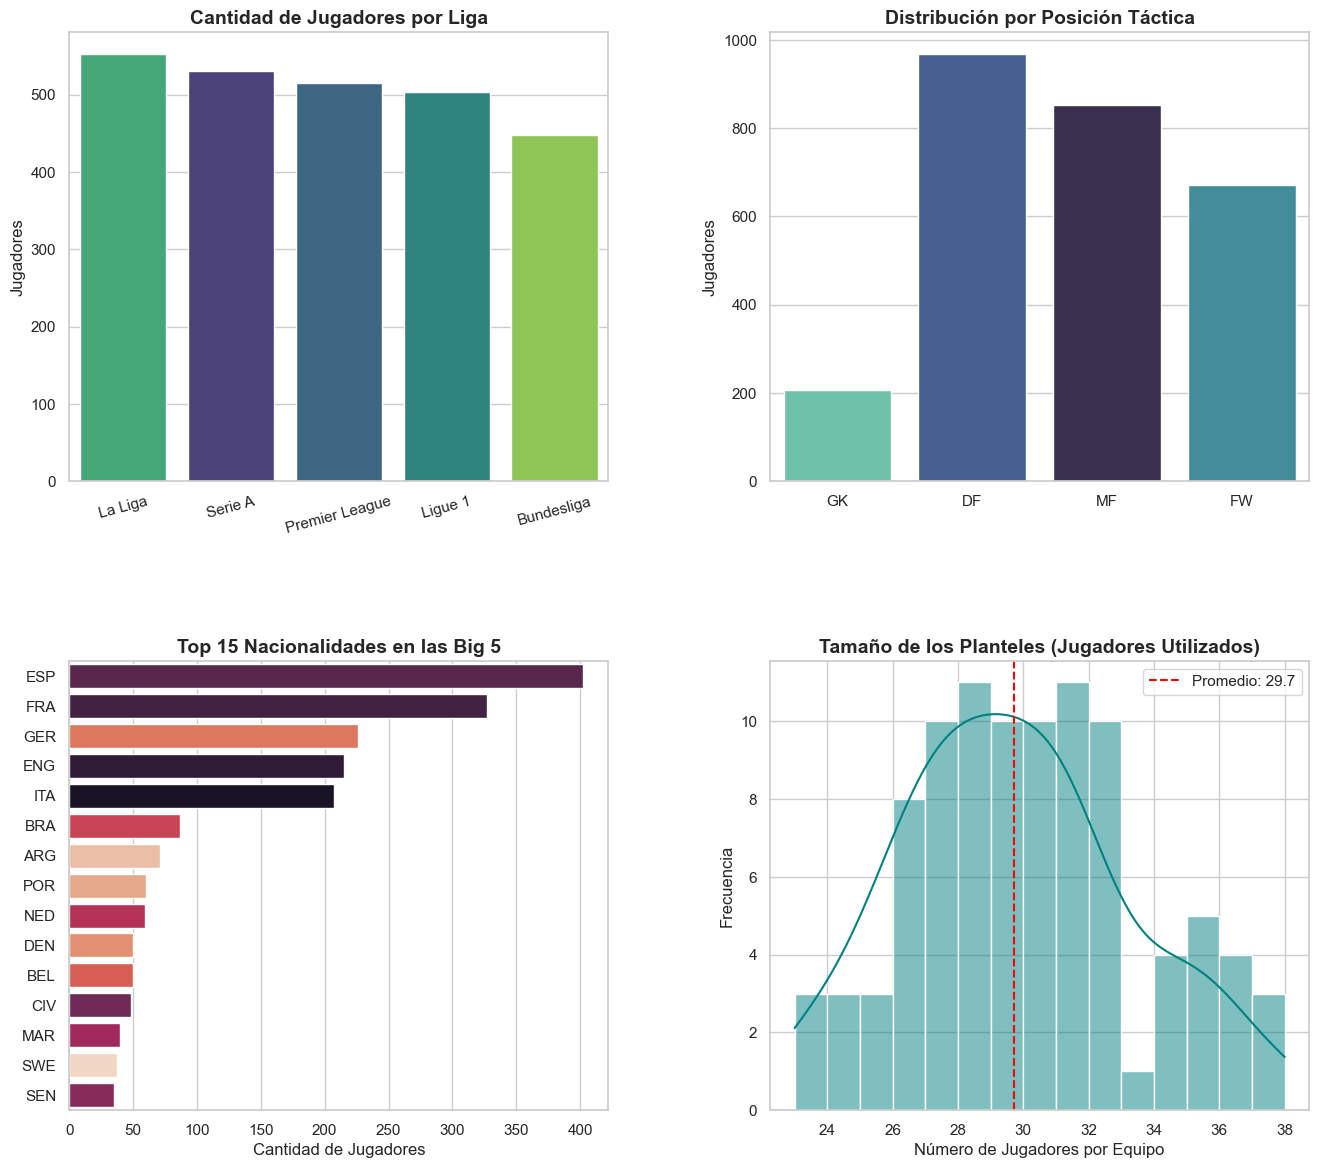


🔎 DATOS CURIOSOS:
- Equipo con más jugadores utilizados: Valladolid (38)
- Equipo con menos jugadores utilizados: Leverkusen (23)
- Nacionalidad dominante: ESP


In [ ]:
# ESTADÍSTICAS DESCRIPTIVAS POR LIGAS

# 2. FILTRADO INTELIGENTE (LA CORRECCIÓN)
# Queremos 1 fila por jugador. Si tiene 'Total', usamos esa. Si no, su única fila.
# Ordenamos: team_order 0 (Total) va primero que 1, 2...
df_sorted = df.sort_values(by=['player_name', 'team_order'], ascending=[True, True])
df_unique = df_sorted.drop_duplicates(subset='player_name', keep='first').copy()

# Filtramos Ligas Múltiples SOLO para el gráfico de ligas (para que no salga la barra "Multiple")
# Pero mantenemos los datos del jugador (asignados a su liga principal si es posible, o los excluimos de ese gráfico específico)
df_unique_leagues = df_unique[df_unique['league_id'] != 'Multiple']

print(f"👥 Población Total Única: {len(df_unique)} jugadores")
print(f"👥 Población para Análisis de Ligas: {len(df_unique_leagues)} jugadores")

# Configuración Visual
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- GRÁFICO 1: BALANCE DE LIGAS ---
# Usamos el DF filtrado sin "Multiple"
sns.countplot(
    data=df_unique_leagues, 
    x='league_id', 
    hue='league_id', 
    palette='viridis', 
    ax=axes[0,0], 
    order=df_unique_leagues['league_id'].value_counts().index,
    legend=False
)
axes[0,0].set_title('Cantidad de Jugadores por Liga', fontsize=14, fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=15)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Jugadores')

# --- GRÁFICO 2: BALANCE DE POSICIONES ---
sns.countplot(
    data=df_unique, 
    x='main_position_group', 
    hue='main_position_group', 
    palette='mako', 
    ax=axes[0,1], 
    order=['GK', 'DF', 'MF', 'FW'],
    legend=False
)
axes[0,1].set_title('Distribución por Posición Táctica', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Jugadores')

# --- GRÁFICO 3: MAPA DE PODER (NACIONALIDADES) ---
top_nations = df_unique['nation'].value_counts().head(15).index
sns.countplot(
    data=df_unique[df_unique['nation'].isin(top_nations)], 
    y='nation', 
    hue='nation', 
    palette='rocket', 
    ax=axes[1,0], 
    order=top_nations,
    legend=False
)
axes[1,0].set_title('Top 15 Nacionalidades en las Big 5', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Cantidad de Jugadores')
axes[1,0].set_ylabel('')

# --- GRÁFICO 4: TAMAÑO DE PLANTELES ---
# Usamos el DF original para contar todos los jugadores que pasaron por un equipo
squad_sizes = df['squad'].value_counts()
# Filtramos el equipo ficticio "COMBINED"
squad_sizes = squad_sizes[squad_sizes.index != 'COMBINED']

sns.histplot(squad_sizes, bins=15, kde=True, color='teal', ax=axes[1,1])
axes[1,1].set_title('Tamaño de los Planteles (Jugadores Utilizados)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Número de Jugadores por Equipo')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].axvline(squad_sizes.mean(), color='red', linestyle='--', label=f'Promedio: {squad_sizes.mean():.1f}')
axes[1,1].legend()

plt.show()

# --- DATOS CURIOSOS ---
print("\n🔎 DATOS CURIOSOS:")
print(f"- Equipo con más jugadores utilizados: {squad_sizes.idxmax()} ({squad_sizes.max()})")
print(f"- Equipo con menos jugadores utilizados: {squad_sizes.idxmin()} ({squad_sizes.min()})")
print(f"- Nacionalidad dominante: {df_unique['nation'].mode()[0]}")


>>> RADIOGRAFÍA DETALLADA POR LIGAS (2 Variables por Aspecto). PROMEDIOS <<<


,goals,xg,assists,progressive_passes,tackles_total,interceptions,progressive_carries,dribbles_completed,save_pct,clean_sheets
league_id,,,,,,,,,,
Bundesliga,1.90,1.84,1.36,46.97,19.30,10.65,18.88,8.60,4.94,0.31
La Liga,1.61,1.66,1.12,46.07,20.59,10.15,20.44,9.62,5.00,0.32
Ligue 1,1.60,1.69,1.11,43.46,19.88,10.02,19.58,8.60,4.31,0.26
Premier League,1.89,1.92,1.40,48.93,23.30,10.51,24.83,10.37,5.06,0.31
Serie A,1.47,1.47,1.05,41.24,18.21,8.81,19.75,7.62,5.24,0.33



>>> BOX PLOTS POR LIGA <<<


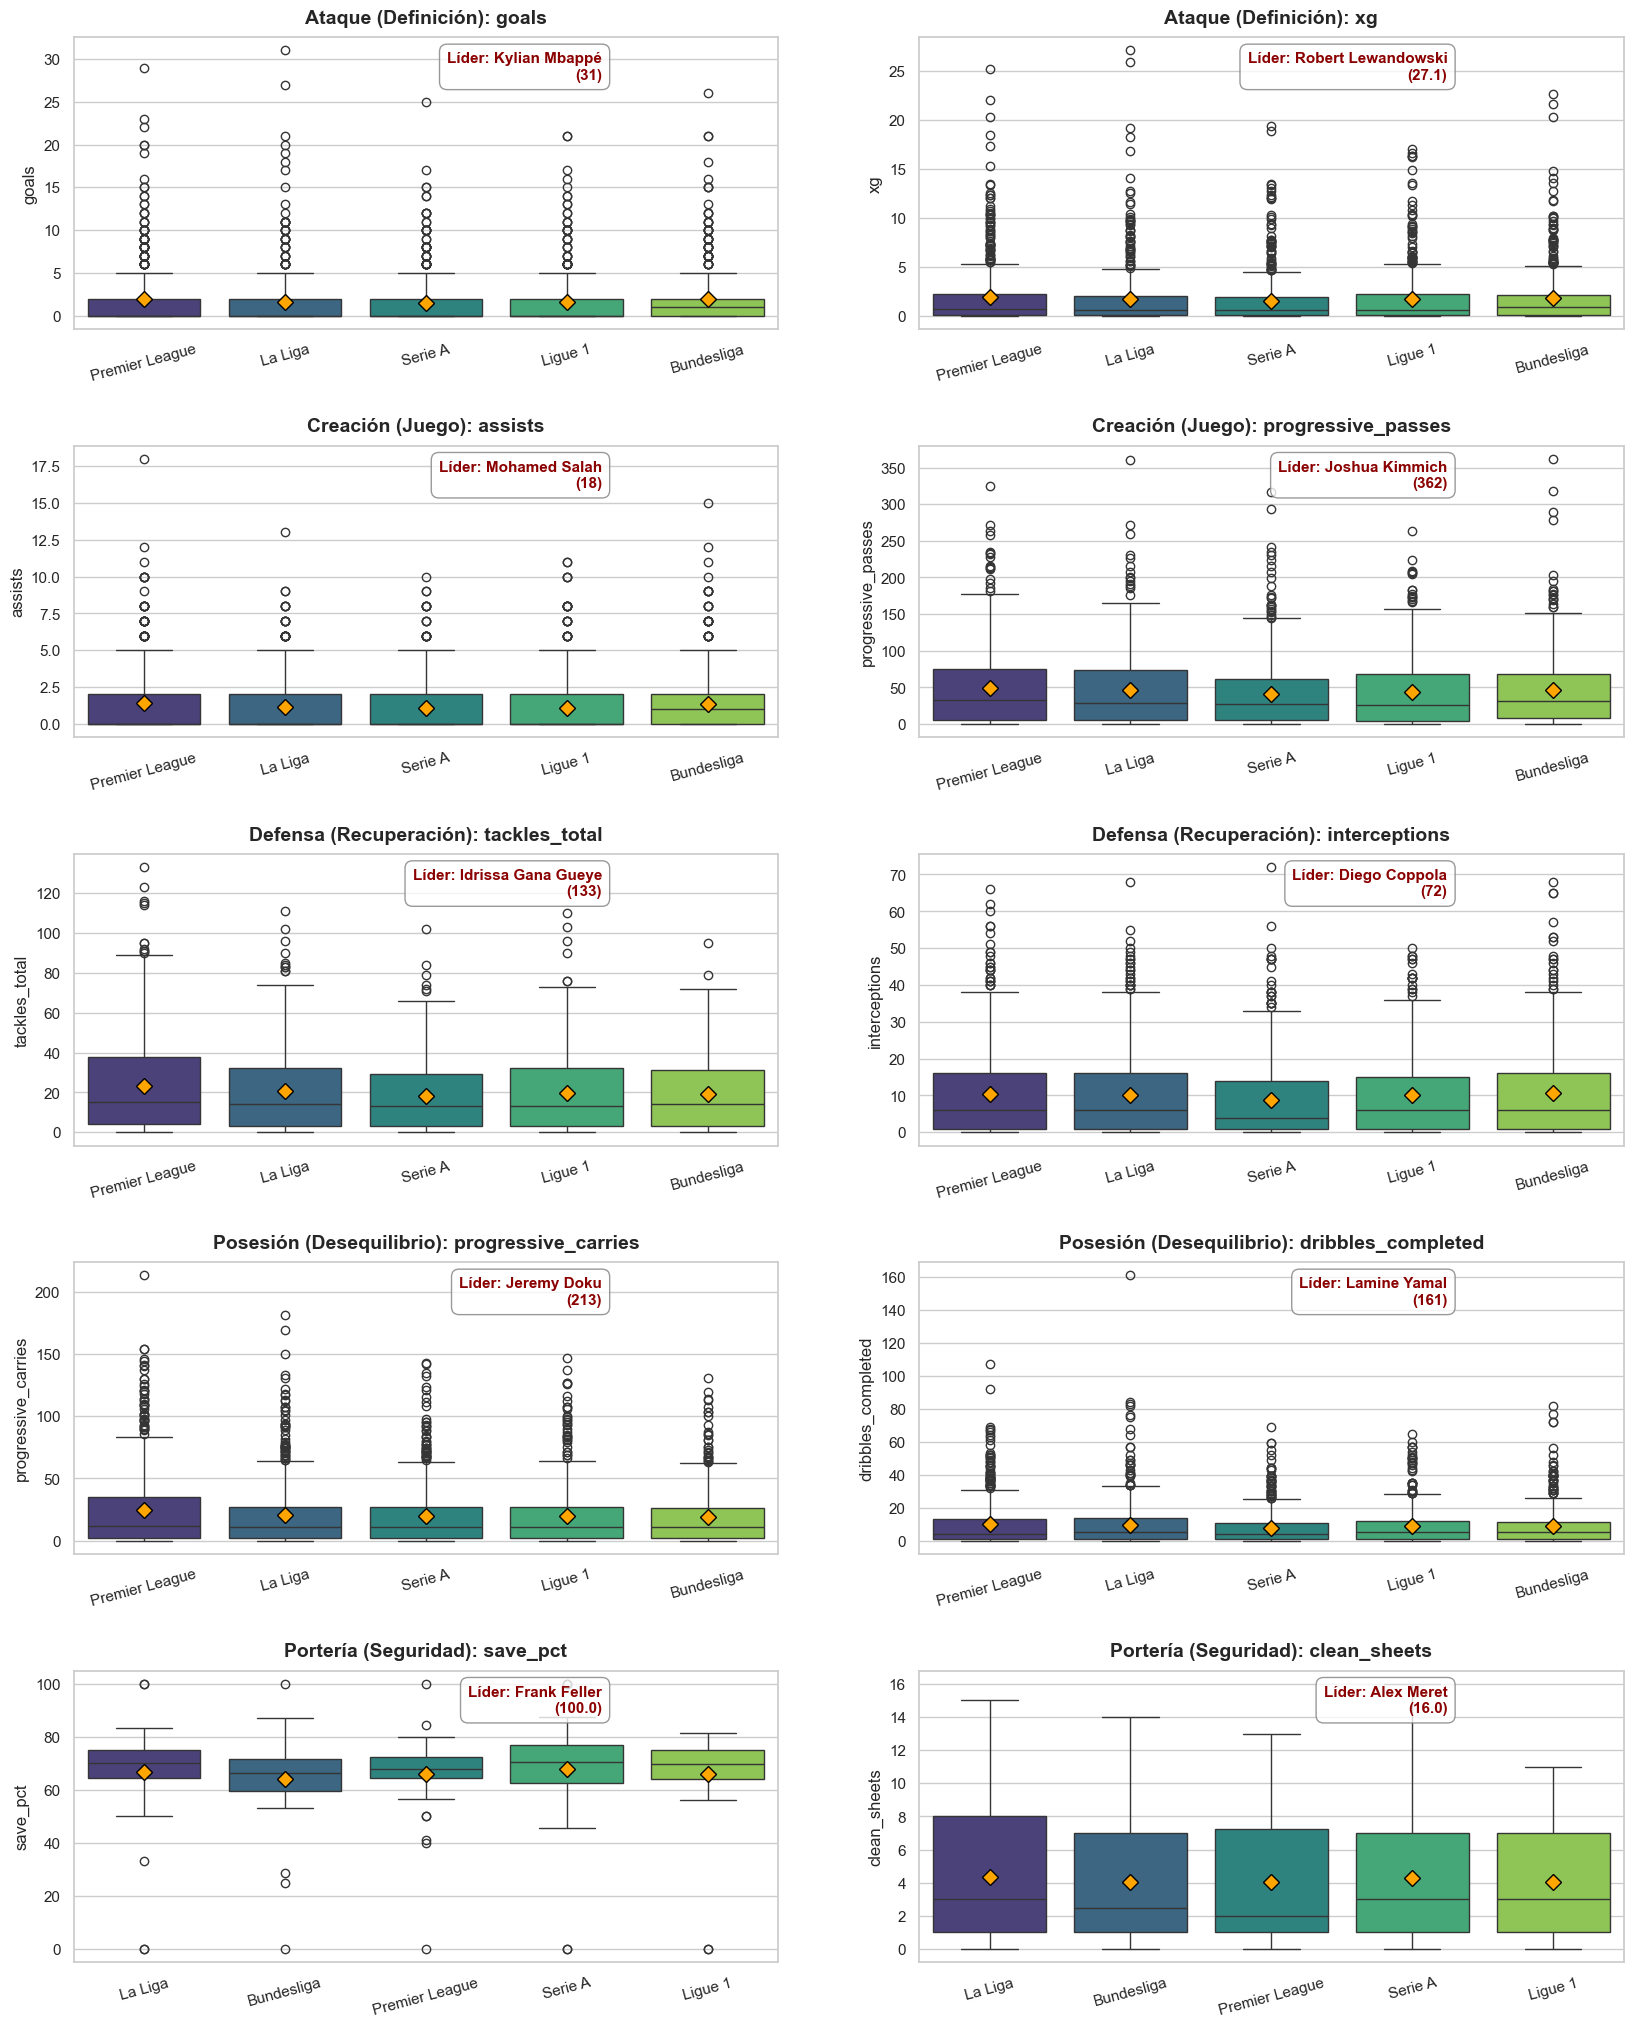

In [ ]:
# BOX PLOT DE VARIABLES SELECCIONADAS

# 1. FILTRO ESTRATÉGICO
df_leagues = df[df['league_id'] != 'Multiple'].copy()

# 2. SELECCIÓN DE VARIABLES
metrics_aspects = {
    'Ataque (Definición)': ['goals', 'xg'],
    'Creación (Juego)': ['assists', 'progressive_passes'],
    'Defensa (Recuperación)': ['tackles_total', 'interceptions'],
    'Posesión (Desequilibrio)': ['progressive_carries', 'dribbles_completed'],
    'Portería (Seguridad)': ['save_pct', 'clean_sheets']
}

# 3. TABLA COMPARATIVA DE PROMEDIOS
print("\n>>> RADIOGRAFÍA DETALLADA POR LIGAS (2 Variables por Aspecto). PROMEDIOS <<<")
league_stats = df_leagues.groupby('league_id')[all_metrics].mean()
display(league_stats.style.background_gradient(cmap='Greens', axis=0).format("{:.2f}"))

# 4. GRÁFICO BOX PLOT
print("\n>>> BOX PLOTS POR LIGA <<<")

# 4.1 CONFIGURACIÓN VISUAL ROBUSTA
plt.rcParams['figure.figsize'] = (20, 22)
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(5, 2, figsize=(20, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

row = 0
for aspect, metrics in metrics_aspects.items():
    col = 0
    for metric in metrics:
        if metric in df_leagues.columns:
            # Filtro de datos
            if aspect == 'Portería (Seguridad)':
                 data_to_plot = df_leagues[df_leagues['main_position_group'] == 'GK']
            else:
                 data_to_plot = df_leagues

            # DIBUJAR BOXPLOT CON MEDIA VISIBLE
            sns.boxplot(
                data=data_to_plot, 
                x='league_id', 
                y=metric,
                hue='league_id',
                legend=False, 
                ax=axes[row, col], 
                palette='viridis',
                showfliers=True,
                
                # --- AQUÍ ESTÁ EL CAMBIO PARA VER LA MEDIA ---
                showmeans=True, 
                meanprops={
                    "marker": "D",              # Forma: Rombo (Diamond)
                    "markerfacecolor": "orange", # Color: Blanco brillante
                    "markeredgecolor": "black", # Borde: Negro para contraste
                    "markersize": 8             # Tamaño: Grande
                }
            )
            
            # Títulos y Ejes
            axes[row, col].set_title(f'{aspect}: {metric}', fontsize=14, fontweight='bold', pad=10)
            axes[row, col].tick_params(axis='x', rotation=15, labelsize=11)
            axes[row, col].set_xlabel('')
            
            # --- ETIQUETAR AL LÍDER ---
            if not data_to_plot.empty:
                max_val = data_to_plot[metric].max()
                best_idx = data_to_plot[metric].idxmax()
                
                if best_idx in data_to_plot.index:
                    best_player = data_to_plot.loc[best_idx, 'player_name']
                    
                    axes[row, col].text(
                        x=0.75, y=0.95, 
                        s=f"Líder: {best_player}\n({max_val})", 
                        transform=axes[row, col].transAxes, 
                        ha='right', va='top', 
                        fontsize=11, color='darkred', fontweight='bold',
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5')
                    )

        col += 1
    row += 1

plt.show()

In [ ]:
# Selección de métricas clave (Cuantitativas)
metrics = [
    'age', 'matches_played', 'minutes_played', 
    'goals', 'assists', 'xg', 'xa', 
    'tackles_total', 'progressive_passes', 'saves'
]
# Filtrar solo las existentes
metrics = [c for c in metrics if c in df.columns]

# --- A. ESTADÍSTICAS DESCRIPTIVAS GLOBALES ---
print("📊 ESTADÍSTICAS GLOBALES (Todas las Ligas)")
print("="*60)
global_desc = df[metrics].describe().T
global_desc['median'] = df[metrics].median() # Añadimos la mediana para ver sesgos

# Reordenamos para facilitar la lectura
cols_order = ['count', 'mean', 'median', 'std', 'min', 'max', '25%', '75%']
display(global_desc[cols_order])

# --- B. COMPARATIVA POR LIGAS (Valores Medios) ---
print("\n🏆 PROMEDIOS POR LIGA (Comparativa de Estilos)")
print("="*60)
league_means = df.groupby('league_id')[metrics].mean()
display(league_means.style.background_gradient(cmap='Greens', axis=0)) # Colorear para ver quién gana

📊 ESTADÍSTICAS GLOBALES (Todas las Ligas)


,count,mean,median,std,min,max,25%,75%
age,3006.0,24.983367,25.0,4.463241,15.0,41.0,22.0,28.0
matches_played,3006.0,19.178643,20.0,11.380912,1.0,54.0,9.0,29.0
minutes_played,3006.0,1215.608117,1063.0,955.450157,1.0,3420.0,343.5,1971.5
goals,3006.0,1.696939,0.0,3.143433,0.0,31.0,0.0,2.0
assists,3006.0,1.198935,0.0,1.929113,0.0,18.0,0.0,2.0
xg,3006.0,1.725349,0.7,2.800914,0.0,27.1,0.1,2.1
xa,3006.0,1.180472,0.6,1.584785,0.0,12.6,0.1,1.6
tackles_total,3006.0,20.333001,14.0,20.479913,0.0,133.0,3.0,32.0
progressive_passes,3006.0,45.334664,30.0,49.601297,0.0,362.0,6.0,69.0
saves,3006.0,3.395210,0.0,16.181114,0.0,150.0,0.0,0.0



🏆 PROMEDIOS POR LIGA (Comparativa de Estilos)


,age,matches_played,minutes_played,goals,assists,xg,xa,tackles_total,progressive_passes,saves
league_id,,,,,,,,,,
Bundesliga,25.203252,19.365854,1228.337398,1.898374,1.363821,1.842073,1.499390,19.296748,46.971545,3.632114
La Liga,25.351082,19.800333,1248.434276,1.612313,1.119800,1.656240,1.131614,20.592346,46.069884,3.391015
Ligue 1,24.112116,17.019892,1092.159132,1.600362,1.106691,1.687703,1.162025,19.878843,43.461121,3.403255
Multiple,24.723684,22.289474,1292.197368,1.960526,1.164474,2.071711,1.221711,21.993421,47.467105,1.256579
Premier League,25.033101,20.151568,1308.240418,1.885017,1.400697,1.919164,1.247387,23.296167,48.930314,3.958188
Serie A,25.241325,18.700315,1180.061514,1.471609,1.052050,1.474606,0.924921,18.206625,41.235016,3.211356


#### 2. La "Frontera de la Relevancia" (Análisis de Volumen)

In [ ]:
# ==============================================================================
# PARTE 2: ANÁLISIS INTRA-GRUPAL (POR POSICIONES)
# ==============================================================================
print("\n" + "="*50)
print("2. ANÁLISIS INTRA-GRUPAL (SEGREGACIÓN POSICIONAL)")
print("="*50)

# Filtramos "ruido" para este análisis (Jugadores > 450 min)
df_core = df[df['minutes_played'] > 450].copy()
print(f"Analizando subconjunto de {len(df_core)} jugadores con > 450 minutos.")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Grupo Delanteros (FW) - Eficiencia
sns.boxplot(data=df_core, x='main_position_group', y='goals', ax=axes[0,0], palette='viridis')
axes[0,0].set_title('Distribución de GOLES por Posición')

# B. Grupo Creativos (MF) - Progresión
sns.boxplot(data=df_core, x='main_position_group', y='progressive_passes', ax=axes[0,1], palette='mako')
axes[0,1].set_title('Distribución de PASES PROGRESIVOS por Posición')

# C. Grupo Defensivo (DF) - Destrucción
sns.boxplot(data=df_core, x='main_position_group', y='tackles_total', ax=axes[1,0], palette='rocket')
axes[1,0].set_title('Distribución de TACKLES por Posición')

# D. Grupo Porteros (GK) - Trabajo
# Filtramos solo GK para que el gráfico no quede vacío en otras posiciones
df_gk = df_core[df_core['main_position_group'] == 'GK']
if not df_gk.empty:
    sns.violinplot(data=df_gk, y='saves', ax=axes[1,1], color='cyan')
    axes[1,1].set_title('Densidad de ATAJADAS (Solo Arqueros)')
else:
    axes[1,1].text(0.5, 0.5, 'Sin datos de GK suficientes', ha='center')

plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# PARTE 3: ANÁLISIS INTER-GRUPOS Y CONSISTENCIA (MICRO)
# ==============================================================================
print("\n" + "="*50)
print("3. ANÁLISIS DE CONSISTENCIA Y RELACIONES (CRUCE DE VARIABLES)")
print("="*50)

# A. Correlaciones Tácticas (Heatmap)
# ¿Se mueven juntas las métricas defensivas?
cols_def = ['tackles_total', 'interceptions', 'blocks', 'ball_recoveries', 'yellow_cards']
corr_mat = df_core[cols_def].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('3.A. Matriz de Coherencia Defensiva', fontsize=14, fontweight='bold')
plt.show()

# B. Scatter de Anomalías: Goles vs xG
# Buscamos "Overperformers" (Talento/Suerte) y "Underperformers" (Mala racha)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_core, x='xg', y='goals', hue='main_position_group', alpha=0.6, palette='deep')
# Línea de identidad
limit = max(df_core['goals'].max(), df_core['xg'].max())
plt.plot([0, limit], [0, limit], 'r--', alpha=0.5, label='Rendimiento Esperado')
plt.title('3.B. Consistencia Ofensiva: Realidad vs Expectativa', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

# C. Detección de Anomalías Específicas (El caso del "Portero Loco")
# Pregunta del usuario: ¿Hay porteros con muchas tarjetas amarillas?
print("\n--- 3.C. Detección de Anomalías: Porteros Indisciplinados ---")
gks_cards = df_core[df_core['main_position_group'] == 'GK'][['player_name', 'squad', 'yellow_cards']].sort_values('yellow_cards', ascending=False)
top_bad_boys = gks_cards.head(5)

if not top_bad_boys.empty:
    print("Top 5 Arqueros con más amarillas:")
    print(top_bad_boys)
    
    # Gráfico rápido si hay datos
    plt.figure(figsize=(8, 4))
    sns.barplot(data=top_bad_boys, x='yellow_cards', y='player_name', palette='Reds_r')
    plt.title('Anomalía: Arqueros con más Tarjetas Amarillas')
    plt.show()
else:
    print("No se encontraron arqueros con tarjetas en el corte seleccionado.")

print("\n" + "="*50)
print("✅ EDA FINALIZADO. DIAGNÓSTICO COMPLETO.")
print("="*50)